### Importing essential libraries

In [17]:
import time
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 700) 
from matplotlib import pyplot as plt
# !pip install seaborn
import seaborn as sns
import random, os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import Sequential, Module, ModuleList, Linear, Dropout
from torch.nn import ReLU, LeakyReLU, Softplus, Tanh, ELU, SiLU, Hardshrink, Hardsigmoid, Hardswish, LogSigmoid, Sigmoid, Softmax, GELU
from torch.optim import SGD, Adam, Adamax, NAdam, Rprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, MultiplicativeLR, LinearLR
# !pip install torchmetrics
from torchmetrics import F1Score, Precision, Recall, Accuracy, ConfusionMatrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to /home/giorgo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/giorgo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/giorgo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/giorgo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Google Drive and Relative Paths

In [18]:
# from google.colab import drive

# drive.mount('/content/gdrive')

# ROOT = 'gdrive/My Drive/ai2_data/2/'  
ROOT = './'

DATASETS = ROOT + 'datasets/'
VECTORIZERS = ROOT + 'vectorizers/'
GLOVE = ROOT + 'glove/'
SAVED_MODELS = ROOT + 'saved_models/'

### Helpers

In [19]:
def write_data(path, obj):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_data(path):
    return pd.read_pickle(path)

def load_csv(path, sep='\t'):
    return pd.read_csv(path, sep=sep)

def prepare_emb(glove_path):
    df = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
    glove = {key: val.values for key, val in df.T.items()}
    return glove

In [20]:
# !wget -P {GLOVE} http://nlp.stanford.edu/data/glove.6B.zip
# !unzip {GLOVE}glove*.zip -d {GLOVE}

In [21]:
write_data(GLOVE + 'emb.pkl', prepare_emb(GLOVE + 'glove.6B.300d.txt'))

### Reviews Cleanup and Train-Test split

In [22]:
def clean_df(df, model_path):
    df['new_rating'] = df['rating'] >= 7

    sw = stopwords.words('english') 

    sw.append('movie')
    sw.append('film')
    sw.append('br')
    
    sw.remove('not')
    sw.remove('no')

    sw = set(sw)

    df['clean_review'] = df['review'].str.lower()
    df['clean_review'] = df['clean_review'].str.replace('n\'t', ' not')
    df['clean_review'] = df['clean_review'].str.replace(r'(@\S+)|(#\S+)|(http\S+)|(www.\S+)', ' ', regex=True)
    df['clean_review'] = df['clean_review'].str.replace(r'[^a-z]', ' ', regex=True)
    df['clean_review'] = df['clean_review'].map(lambda x: ' '.join([word for word in word_tokenize(x) if not word in sw]))

    model = pd.read_pickle(model_path)
    dims = len(list(model.values())[0])

    def emb(input):
        vectors = [model[word] for word in input.split() if word in model]
        return (sum(vectors) / len(vectors)) if vectors else np.zeros((dims,))
    
    df['emb_review'] = df['clean_review'].apply(emb)

    return df

In [23]:
CLEAN_DATA_PATH = DATASETS + 'imdb-reviews_clean.pkl'

In [24]:
df = load_csv(DATASETS + 'imdb-reviews.csv')
df['movie_id'] = df['url'].rank(method='dense', ascending=False).astype(int)
df = clean_df(df, GLOVE + 'emb.pkl')

write_data(CLEAN_DATA_PATH, df)

In [25]:
import random
random.seed(10)

df = load_data(CLEAN_DATA_PATH)

ids = random.sample(range(max(df['movie_id']) + 1), 300)

df_test = df[df['movie_id'].isin(ids)] 
df = df[~df['movie_id'].isin(ids)] 
write_data(DATASETS + 'um_train.pkl', df)
write_data(DATASETS + 'um_test.pkl', df_test)

In [26]:
df = load_data(CLEAN_DATA_PATH)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df['new_rating'].values)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=1, stratify=train_data['new_rating'].values)

write_data(DATASETS + 'train.pkl', train_data)
write_data(DATASETS + 'val.pkl', val_data)
write_data(DATASETS + 'test.pkl', test_data)

### Dataset

In [27]:
class ClassifierData(Dataset):
    def __init__(self, path, x_label='emb_review', y_label='new_rating', device='cpu'):
        df = load_data(path)

        self.inputs = np.vstack(df[x_label].values).astype(np.float32)
        self.labels = [1. if i == True else 0. for i in df[y_label].values]

        self.inputs = torch.from_numpy(self.inputs).to(device)
        self.labels = torch.tensor(self.labels).to(device)
        self.labels = self.labels.view(self.labels.shape[0], 1)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [28]:
def get_datasets(path, device='cpu'):
    train = ClassifierData(path + 'train.pkl', device=device)
    val   = ClassifierData(path + 'val.pkl', device=device)
    test  = ClassifierData(path + 'test.pkl', device=device)
    return train, val, test

In [29]:
def get_dataloaders(train_data, val_data, test_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

### Train & Test 

In [30]:
def test(dataloader, model, loss_fn, device):
    model.eval()

    samples = len(dataloader)
    loss = 0.0
    predicted, target = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
       
            predicted.append(pred)             
            target.append(y)             
    
    predicted = torch.cat(predicted, dim=0).to(device)
    target = torch.cat(target, dim=0).to(device)
    # target = torch.cat(target, dim=0).to(torch.int).to(device)

    p = Precision(task="binary", num_classes=2).to(device)
    r = Recall(task="binary", num_classes=2).to(device)
    f1 = F1Score(task="binary", num_classes=2).to(device)
    acc = Accuracy(task="binary", num_classes=2).to(device)
    confmat = ConfusionMatrix(task="binary", num_classes=2).to(device)

    p  =  p(predicted, target).item()
    r  =  r(predicted, target).item()
    f1 = f1(predicted, target).item()

    return loss / samples, p, r, f1, acc(predicted, target).item(), confmat(predicted, target), predicted.detach().cpu().numpy(), target.detach().cpu().numpy()

In [ ]:
def epoch(model, t, dataloader, loss_fn, optimizer, show_epochs, scheduler, pass_loss):
    model.train()
    batches = len(dataloader)
    running_loss = 0.0

    if show_epochs:
        print(f"\nEpoch {t+1}\n-------------------------------")

    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)   
        
        loss = loss_fn(pred, y)
        running_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if show_epochs and (not batch or (batch + 1) % 50 == 0):
            lr = optimizer.param_groups[0]['lr']
            print(f'\tbatch {batch+1:>3d} loss: {loss.item():>2.5f}, lr: {lr}')

    if scheduler:
        if pass_loss:
            scheduler.step(loss)
        else:
            scheduler.step()
    
    epoch_loss = running_loss / batches  
    
    if show_epochs:
        print(f"\nEpoch Average Loss: {epoch_loss:>7f}\n")
    
    
    return epoch_loss 

In [31]:
def train(dataloader, model, epochs, loss_fn, optimizer, val_dataloader=None, show_epochs=False, device='cpu', **kwargs):
    scheduler = kwargs['scheduler'] if 'scheduler' in kwargs else None
    pass_loss = kwargs['pass_loss'] if 'pass_loss' in kwargs else False
    patience = kwargs['patience'] if 'patience' in kwargs else None 

    if not patience:
        patience = epochs
    else:
        assert(val_dataloader)

    max_f1 = -1
    last_change = 0

    losses = {'train' : [], 'test' : []}

    for t in range(epochs):
        
        epoch_loss = epoch(model, t, dataloader, loss_fn, optimizer, show_epochs, scheduler, pass_loss)
        losses['train'].append(epoch_loss)

        if val_dataloader:
            val_loss, _, _, f1, _, _, _, _ = test(val_dataloader, model, loss_fn, device)
            
            if show_epochs:
                print(f'F1-score on validation set: {f1*100:>.2f}')

            last_change += 1

            losses['test'].append(val_loss)

            if f1 > max_f1:
                write_data(f'{SAVED_MODELS}model_{device}.pth', model)
                max_f1 = f1
                last_change = 0
            
            if patience < last_change:
                if show_epochs:
                    print(f'No improvement on F1-Score for {last_change} > {patience} (patience) epochs.')
                    print(f'Stopping training after [{t+1:>2d}/{epochs:>2d}] epochs.')
                break

    return np.array(losses['train']), np.array(losses['test'])
            

### Complete pass

#### Reproducibility

In [32]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

#### Confusion Matrix

In [33]:
def confusion_matrix(confmat):
    classes = ['Negative', 'Positive']
    df = pd.DataFrame(np.array(confmat.cpu().detach().numpy()), index=classes, columns=classes)

    plt.figure(figsize=(10,7))
    ax = sns.heatmap(df, annot=True, fmt='.5g', annot_kws={"fontsize":12})
    ax.tick_params(left=True, top=True, bottom=False, labelleft=True, labeltop=True, labelbottom=False)

    plt.title('Predicted', fontsize=20)
    plt.ylabel('True', fontsize=20)
    plt.show()

#### Learning Curve

In [34]:
# Based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def learning_curve(loss_train, loss_test):
    _, axes = plt.subplots(1, 1, figsize=(8,5))

    axes.set_xlabel('Epoch')
    axes.set_ylabel('Loss')

    axes.grid()

    epoch_step = len(loss_train) // 20
    if not epoch_step:
        epoch_step = 1

    xvalues = np.arange(1, len(loss_train) + 1, epoch_step)

    axes.plot(xvalues, loss_train[::epoch_step], "o-", color="r", label="Training loss")
    axes.plot(xvalues, loss_test[::epoch_step], "o-", color="g", label="Validation loss")

    axes.legend(loc="best")

    plt.xticks(np.arange(1, len(loss_train) + epoch_step + 1, epoch_step))
    plt.yticks(np.arange(min(min(loss_train), min(loss_test)) - 0.1, max(max(loss_train), max(loss_test)) + 0.1, 0.05))

    plt.show()

#### ROC curve

In [35]:
def roc(target, pred):
    fpr, tpr, _ = roc_curve(target, pred)
    roc_auc = auc(fpr, tpr)

    _, axes = plt.subplots(1, 1, figsize=(8,5))

    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')

    axes.grid()

    axes.plot(fpr, tpr, '.', color='r', label=f'ROC curve (AUC = {100 * roc_auc : .2f}%)')

    axes.legend(loc="best")

    ticks = np.arange(0, 1.05, 0.2)
    plt.xticks(ticks)
    plt.yticks(ticks)

    plt.show()

#### Pass

In [36]:
def complete_pass(data_path, model, **kwargs):
    # Data 
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 16

    # Architecture
    model_params = kwargs['model_params'] if 'model_params' in kwargs else {}

    # Hyperparameters
    device = kwargs['device'] if 'device' in kwargs else 'cpu'
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 30
    
    # loss_fn = kwargs['loss_fn'] if 'loss_fn' in kwargs else nn.CrossEntropyLoss()
    loss_fn = kwargs['loss_fn'] if 'loss_fn' in kwargs else nn.BCELoss()
    lr = kwargs['lr'] if 'lr' in kwargs else 0.002

    optimizer = kwargs['optimizer'] if 'optimizer' in kwargs else torch.optim.SGD
    # optimizer = kwargs['optimizer'] if 'optimizer' in kwargs else Adam
    kwargs.pop('optimizer', None)
    # optimizer_params = kwargs['optimizer_params'] if 'optimizer_params' in kwargs else {'weight_decay' : 0.0001}
    optimizer_params = kwargs['optimizer_params'] if 'optimizer_params' in kwargs else {}

    scheduler = kwargs['scheduler'] if 'scheduler' in kwargs else None
    scheduler_params = kwargs['scheduler_params'] if 'scheduler_params' in kwargs else {}
    pass_loss = scheduler_params['pass_loss'] if 'pass_loss' in scheduler_params else False
    patience = kwargs['patience'] if 'patience' in kwargs else None    

    # Results
    show_epochs = kwargs['show_epochs'] if 'show_epochs' in kwargs else False
    cmatrix = kwargs['cmatrix'] if 'cmatrix' in kwargs else False
    lc = kwargs['lc'] if 'lc' in kwargs else False
    auroc = kwargs['auroc'] if 'auroc' in kwargs else False

    validate = kwargs['validate'] if 'validate' in kwargs else False
    reproducibility = kwargs['reproducibility'] if 'reproducibility' in kwargs else False


    if reproducibility:
          torch_seed(seed=5)


    train_data, val_data, test_data = get_datasets(data_path, device=device)
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_data, val_data, test_data, batch_size)
    
    model = model(**model_params).to(device)

    optimizer = optimizer(model.parameters(), lr=lr, **optimizer_params)

    if scheduler:
        if pass_loss:
            scheduler_params = dict(scheduler_params)
            del scheduler_params['pass_loss']

        scheduler = scheduler(optimizer, **scheduler_params)

    start_time = time.perf_counter()
    loss_train, loss_test = train(train_dataloader, model, epochs, loss_fn, optimizer, val_dataloader=val_dataloader if validate else None,
                                  show_epochs=show_epochs, device=device, pass_loss=pass_loss, patience=patience, scheduler=scheduler)
    end_time = time.perf_counter()

    if validate:
        model = load_data(f'{SAVED_MODELS}model_{device}.pth')

    loss, p, r, f1, acc, confmat, pred, target = test(test_dataloader, model, loss_fn, device)

    print(f'\nTime taken: {end_time - start_time:>0.2f}', end='\t')
    print(f'Avg loss: {loss:>8f}\tAccuracy: {(100*acc):>0.2f}%\n')
    print(f'Precision: {(100*p):>0.2f}%\tRecall: {(100*r):>0.2f}%\t\tF1-Score: {(100*f1):>0.2f}%')

    if cmatrix:
        confusion_matrix(confmat)

    if lc:
        learning_curve(loss_train, loss_test)

    if auroc:
        roc(target, pred)

### Neural Network

In [37]:
class NeuralNetwork(Module):
    def __init__(self, in_dim, **kwargs):
        super(NeuralNetwork, self).__init__()

        linear_layers = [in_dim] + (kwargs['layers'] if 'layers' in kwargs else [1024, 256, 32]) + [1]
        num_of_layers = len(linear_layers) - 1

        activation = kwargs['activation'] if 'activation' in kwargs else None
        dropout = kwargs['dropout'] if 'dropout' in kwargs else None

        if dropout:
            if type(dropout) != list:
                dropout = [dropout] * num_of_layers

            assert(len(dropout) == num_of_layers)

        if activation:
            if type(activation) != list:
                activation = [activation] * num_of_layers

            assert(len(activation) == num_of_layers)


        self.layers = nn.ModuleList()

        for i in range(num_of_layers):
            if dropout:
                self.layers.append(Dropout(dropout[i]))

            self.layers.append(Linear(linear_layers[i], linear_layers[i + 1]))

            if activation:
                self.layers.append(activation[i]() if i != num_of_layers - 1 else Sigmoid())        

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

### Experimenting

#### One hidden layer NN

##### Base


Time taken: 111.22	Avg loss: 0.371714	Accuracy: 83.69%

Precision: 81.41%	Recall: 87.34%		F1-Score: 84.27%


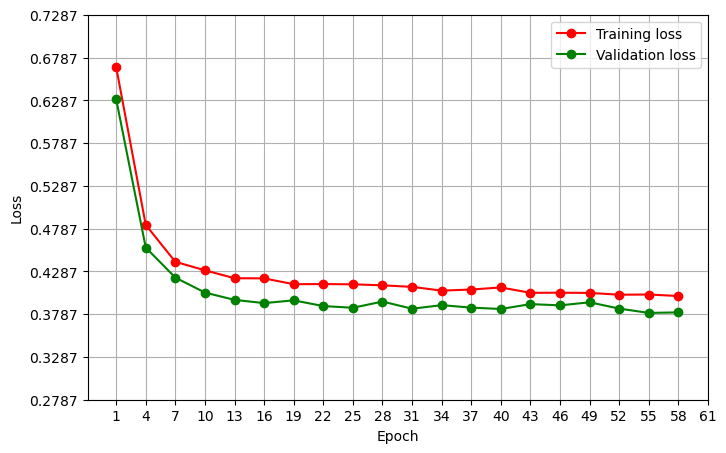

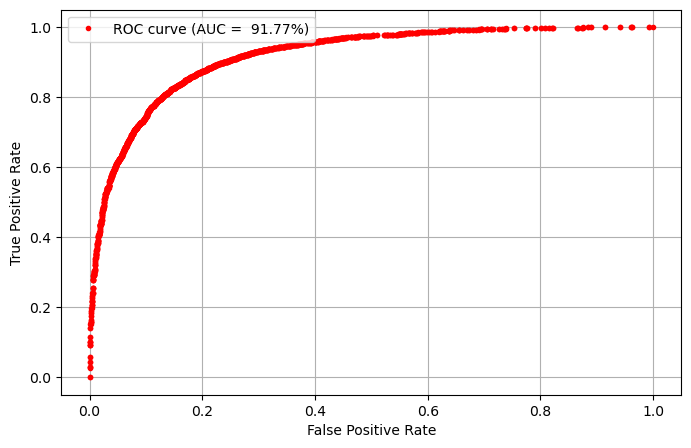

In [38]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              )


Time taken: 113.88	Avg loss: 0.372010	Accuracy: 83.70%

Precision: 81.41%	Recall: 87.36%		F1-Score: 84.28%


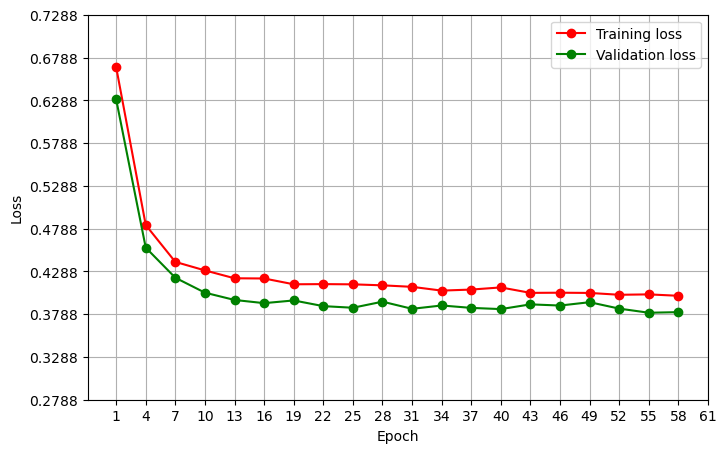

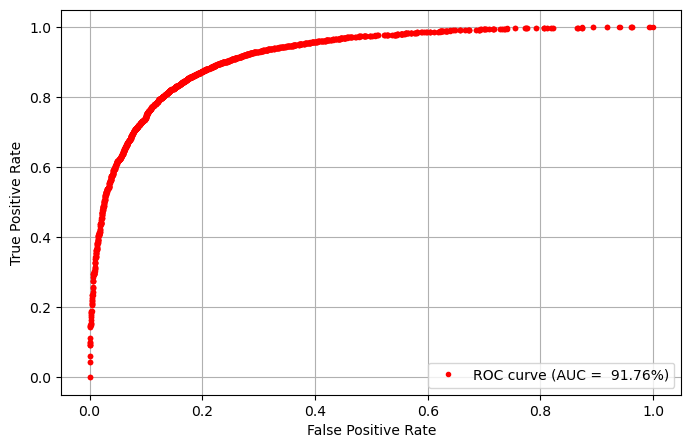

In [39]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              )


Time taken: 111.32	Avg loss: 0.382408	Accuracy: 83.48%

Precision: 81.66%	Recall: 86.36%		F1-Score: 83.95%


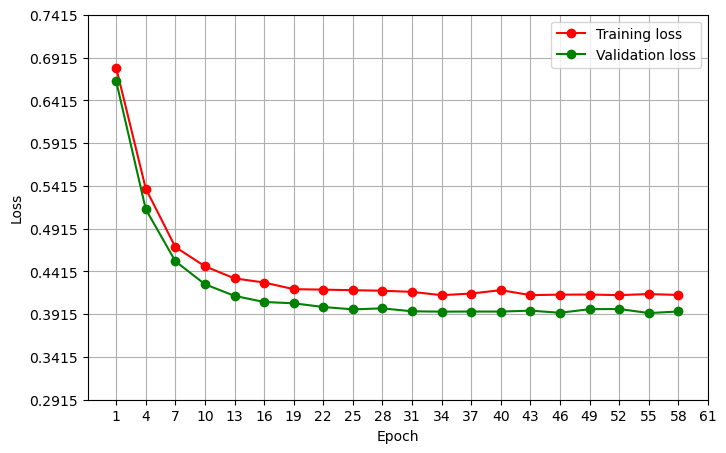

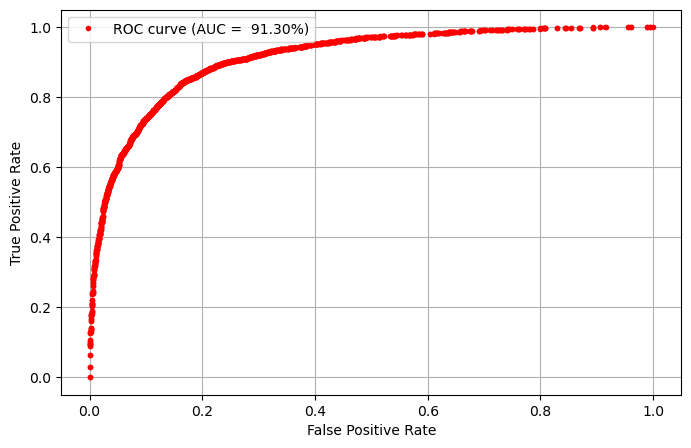

In [40]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              )

##### Adam


Time taken: 147.89	Avg loss: 0.385689	Accuracy: 84.20%

Precision: 83.13%	Recall: 85.83%		F1-Score: 84.46%


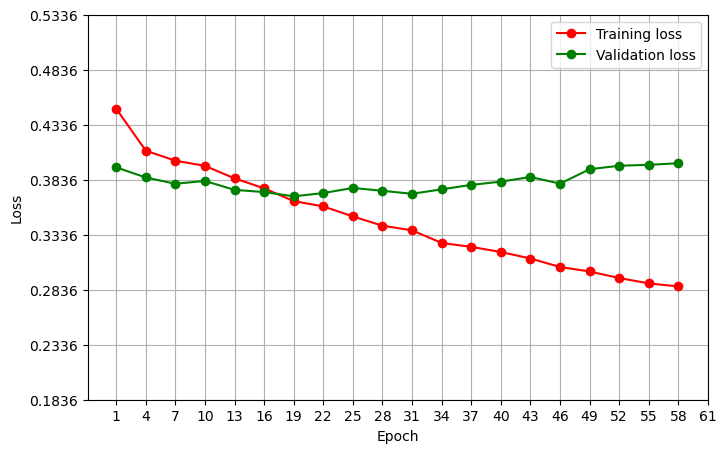

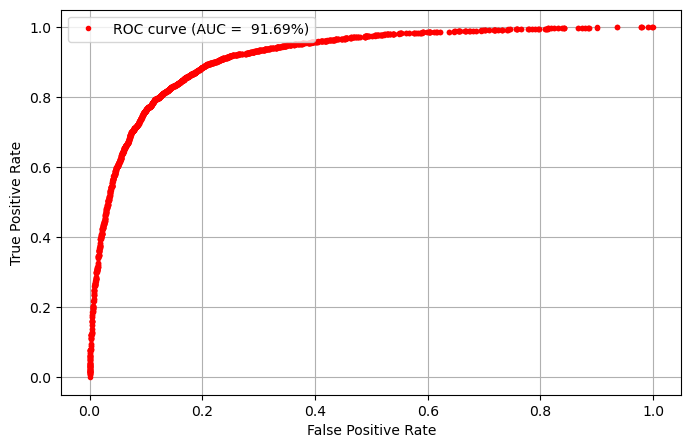

In [41]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,
              )


Time taken: 149.89	Avg loss: 0.369244	Accuracy: 84.73%

Precision: 83.37%	Recall: 86.76%		F1-Score: 85.03%


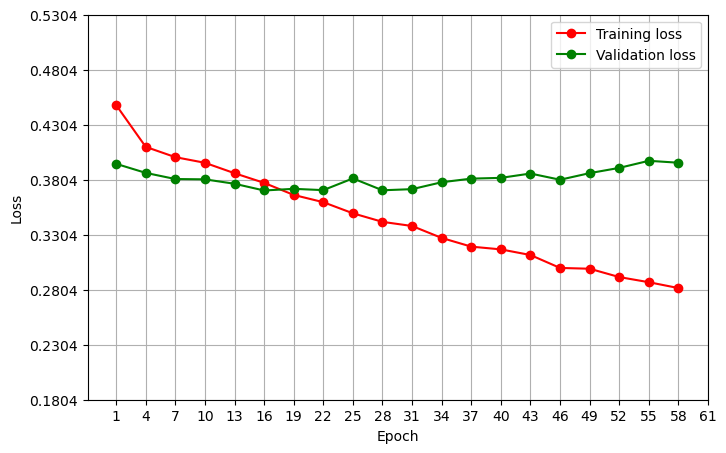

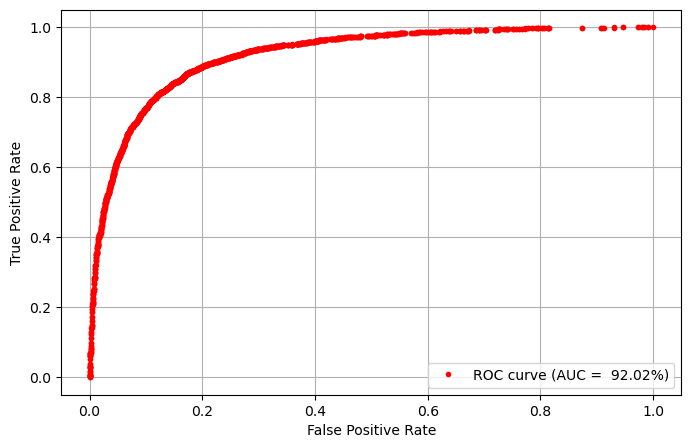

In [42]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,
              )


Time taken: 149.26	Avg loss: 0.356862	Accuracy: 84.53%

Precision: 82.10%	Recall: 88.32%		F1-Score: 85.09%


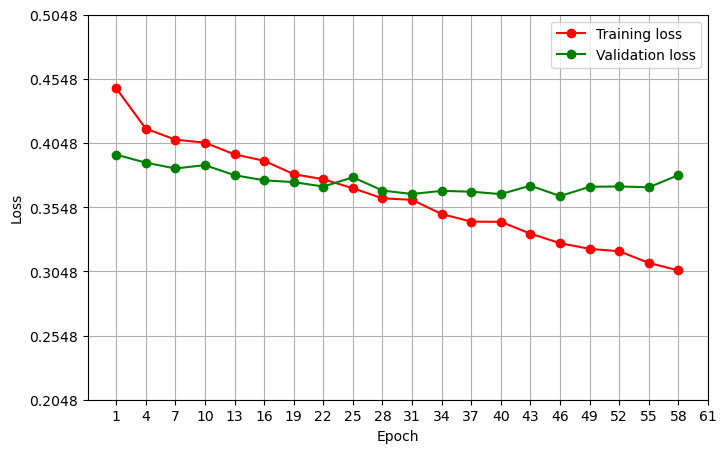

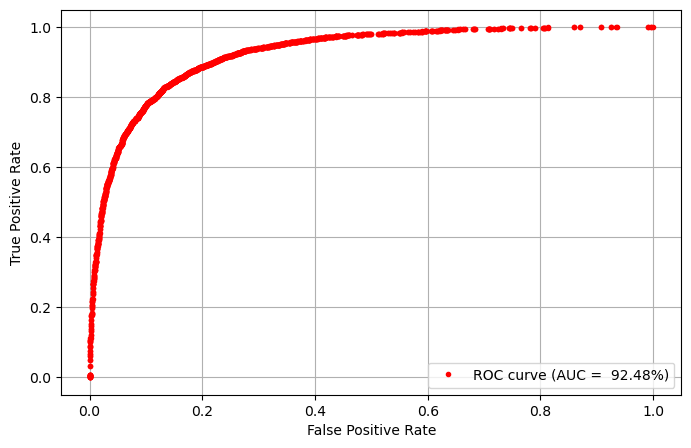

In [43]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,
              )


Time taken: 150.29	Avg loss: 0.346470	Accuracy: 84.78%

Precision: 83.15%	Recall: 87.25%		F1-Score: 85.15%


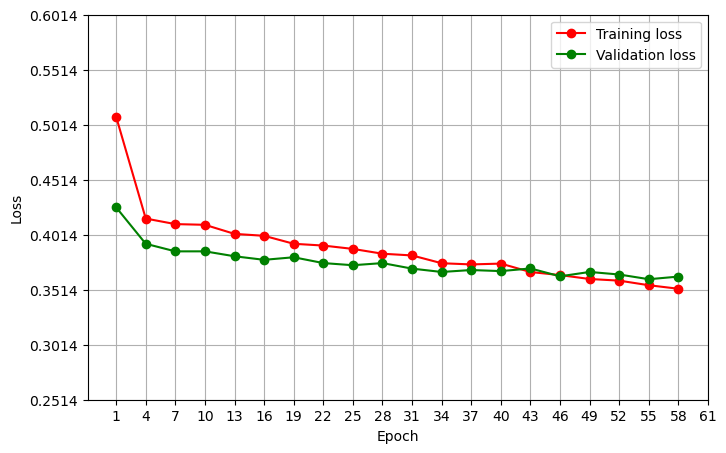

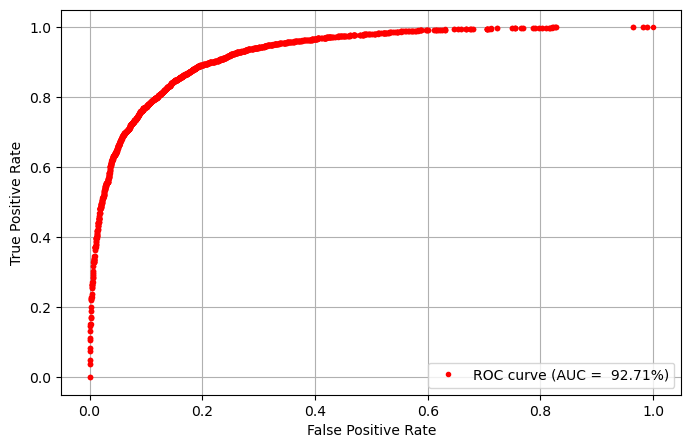

In [44]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False}
              )


Time taken: 149.26	Avg loss: 0.346571	Accuracy: 84.93%

Precision: 83.28%	Recall: 87.41%		F1-Score: 85.29%


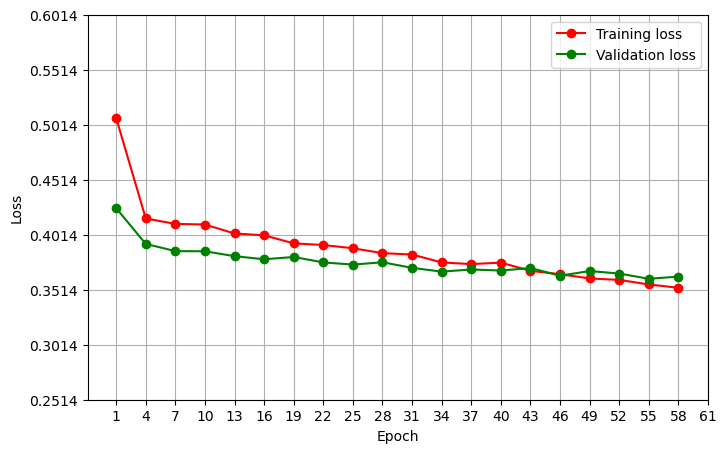

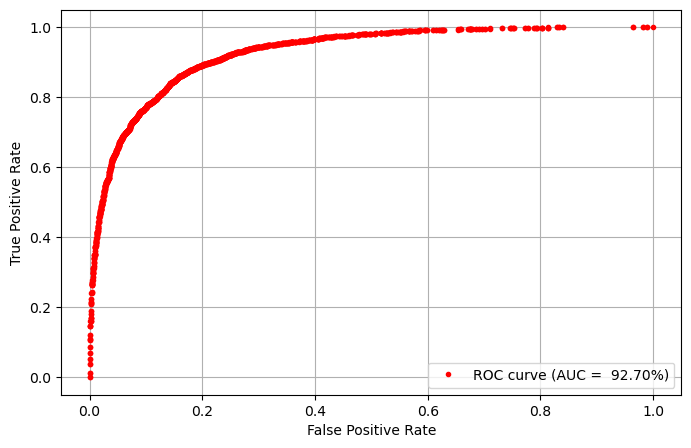

In [45]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False}
              )


Time taken: 150.04	Avg loss: 0.375478	Accuracy: 83.83%

Precision: 81.94%	Recall: 86.78%		F1-Score: 84.29%


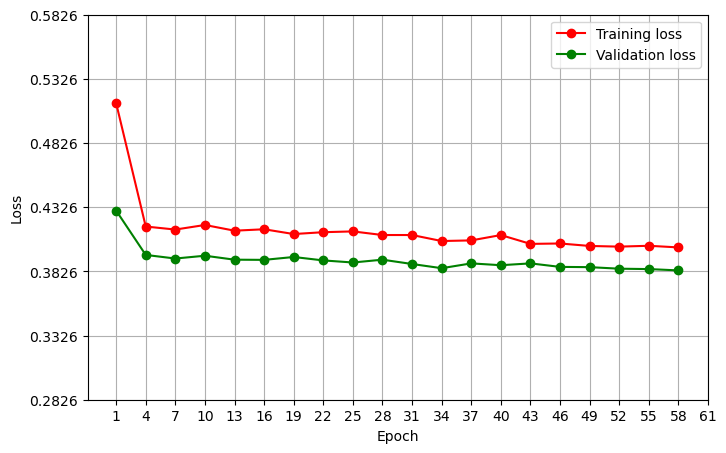

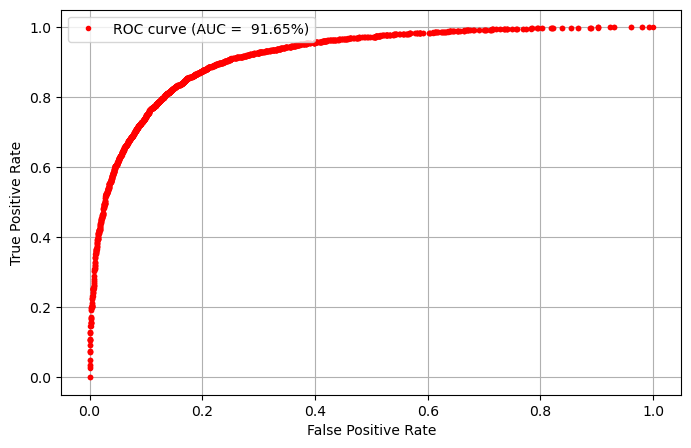

In [46]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False}
              )


Time taken: 150.38	Avg loss: 0.350257	Accuracy: 84.41%

Precision: 84.05%	Recall: 84.96%		F1-Score: 84.50%


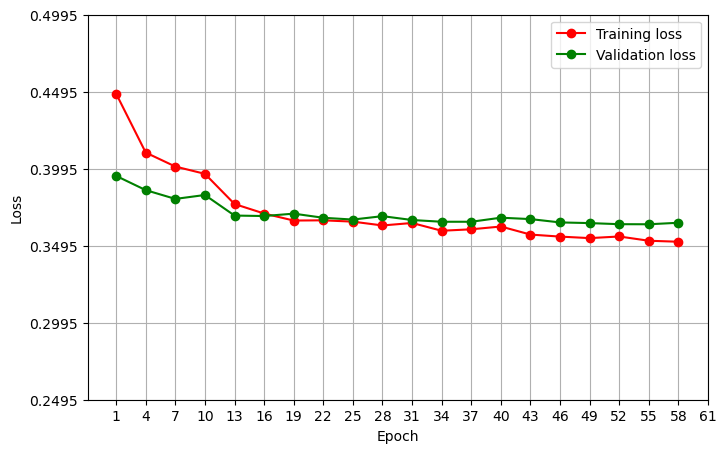

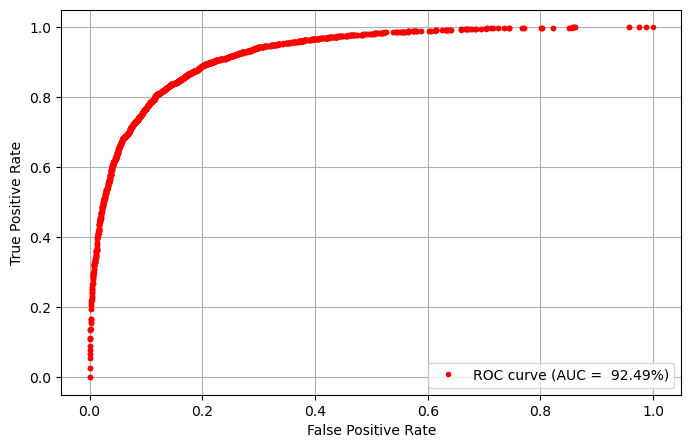

In [47]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 148.58	Avg loss: 0.347046	Accuracy: 84.51%

Precision: 83.97%	Recall: 85.32%		F1-Score: 84.64%


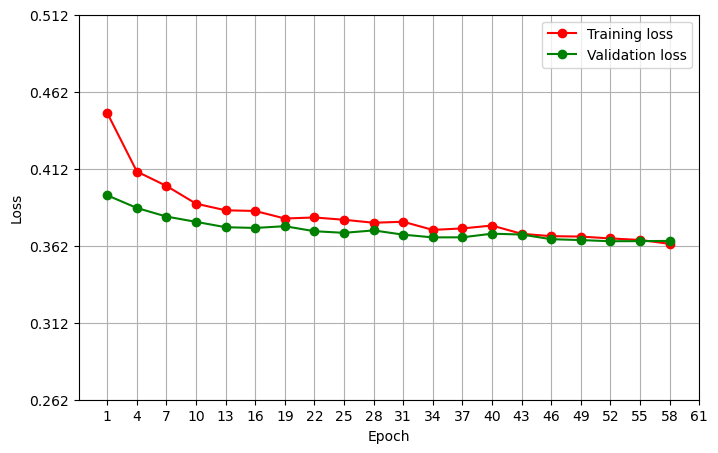

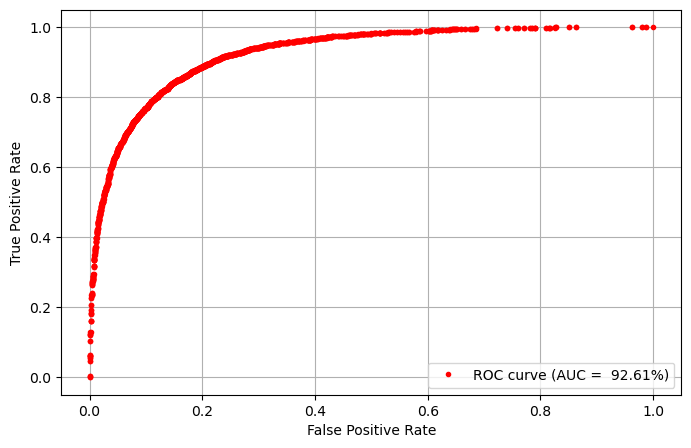

In [48]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 148.93	Avg loss: 0.359751	Accuracy: 84.30%

Precision: 83.53%	Recall: 85.47%		F1-Score: 84.49%


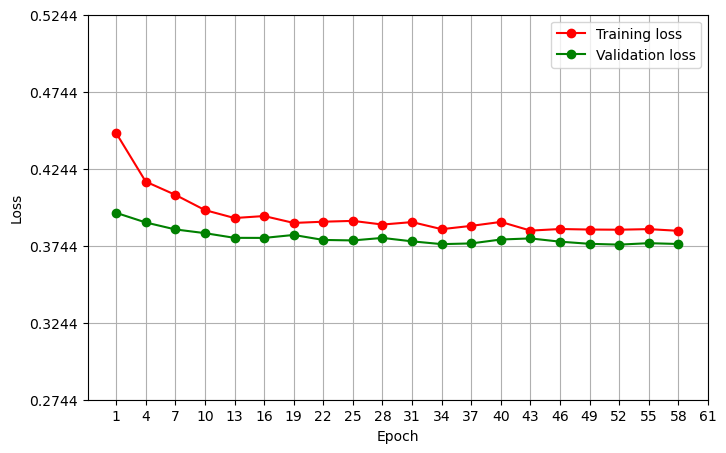

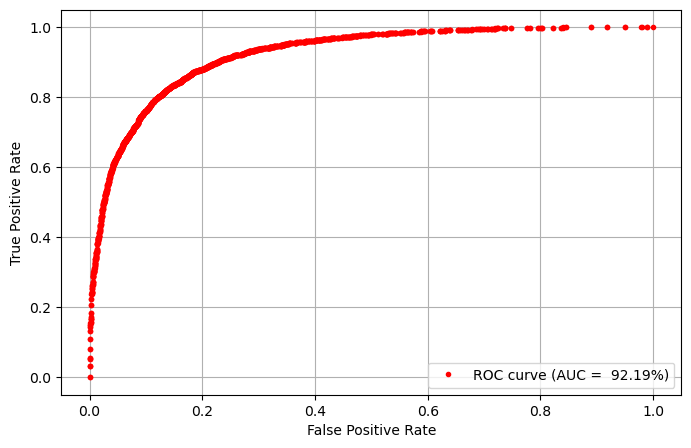

In [49]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 149.12	Avg loss: 0.352952	Accuracy: 84.41%

Precision: 83.85%	Recall: 85.25%		F1-Score: 84.55%


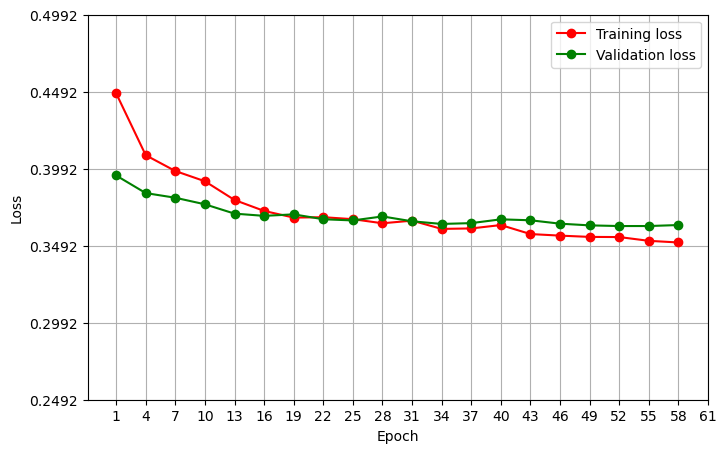

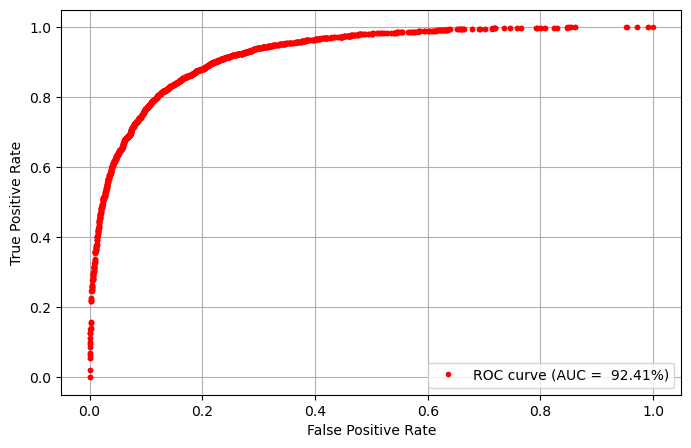

In [50]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 150.65	Avg loss: 0.343661	Accuracy: 84.54%

Precision: 84.01%	Recall: 85.32%		F1-Score: 84.66%


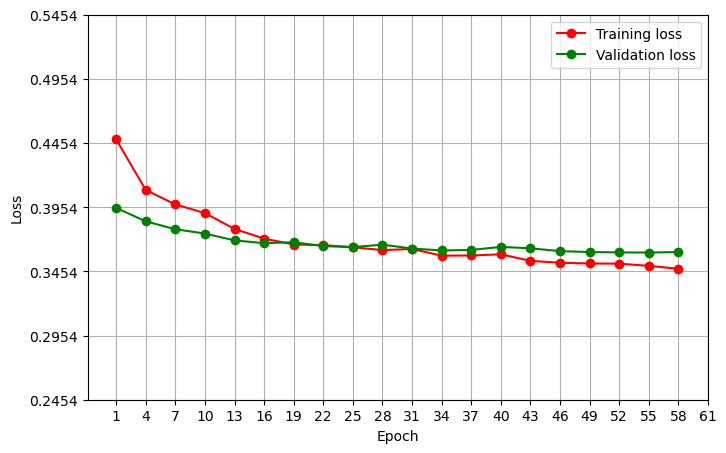

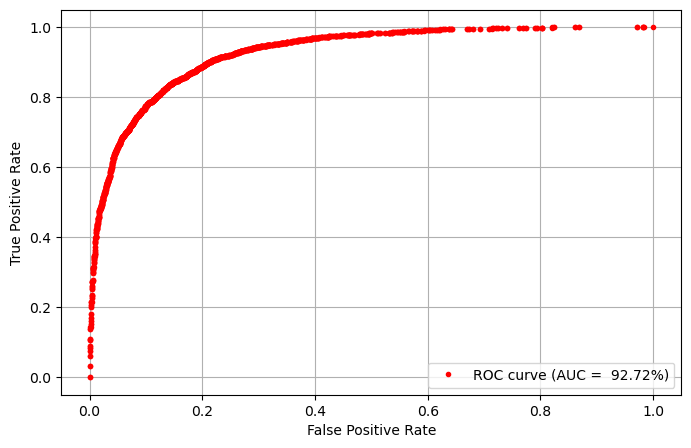

In [51]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 148.69	Avg loss: 0.360704	Accuracy: 84.24%

Precision: 83.56%	Recall: 85.25%		F1-Score: 84.40%


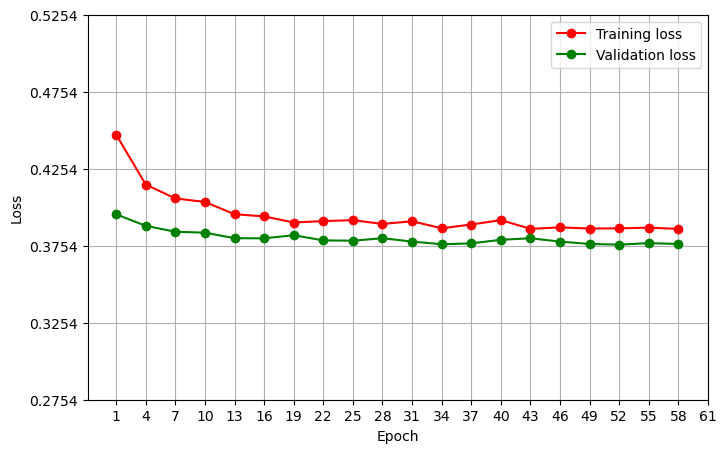

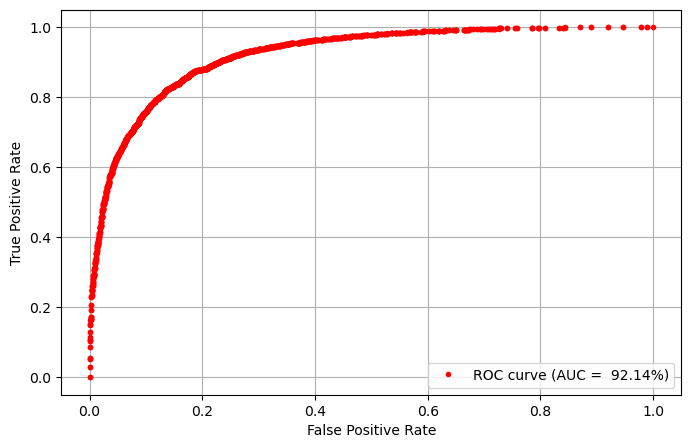

In [52]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )

##### Adamax


Time taken: 157.10	Avg loss: 0.351681	Accuracy: 84.89%

Precision: 83.19%	Recall: 87.47%		F1-Score: 85.28%


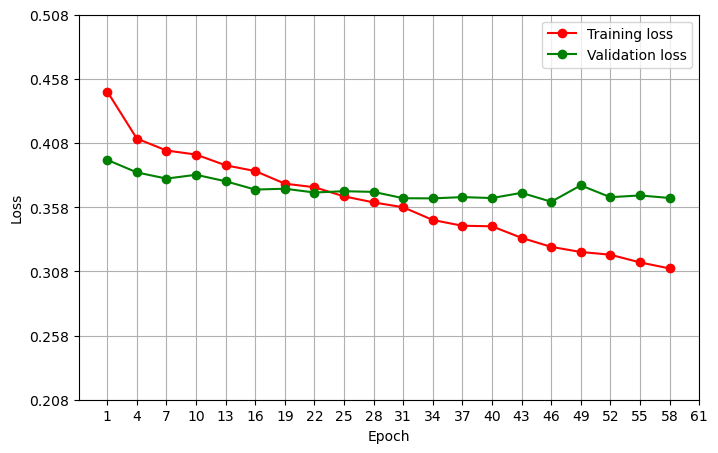

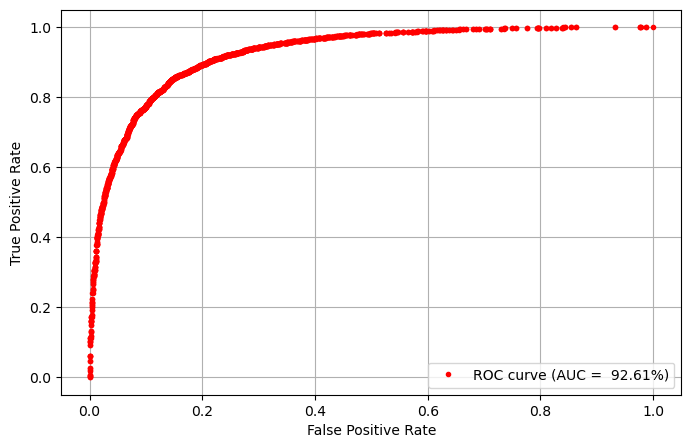

In [53]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,
              )


Time taken: 156.04	Avg loss: 0.352329	Accuracy: 84.74%

Precision: 82.82%	Recall: 87.67%		F1-Score: 85.17%


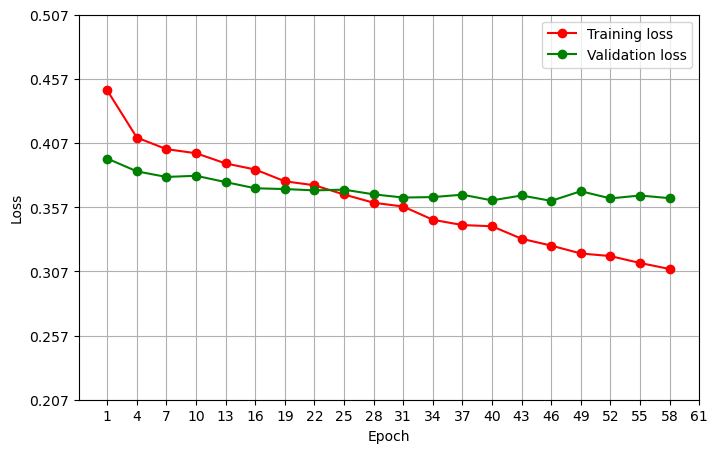

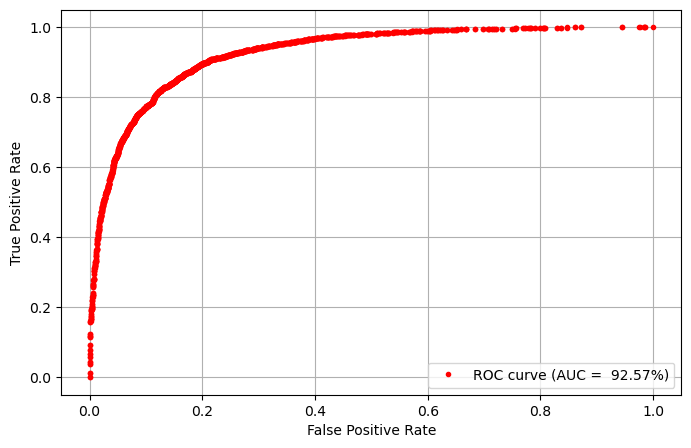

In [54]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,
              )


Time taken: 158.57	Avg loss: 0.351453	Accuracy: 84.69%

Precision: 82.34%	Recall: 88.34%		F1-Score: 85.23%


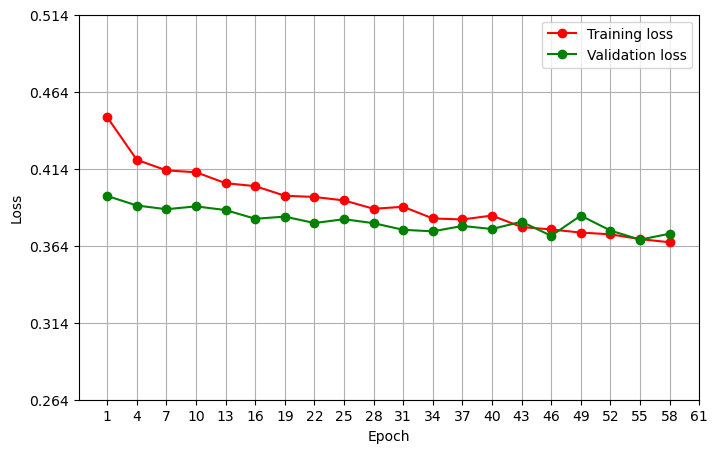

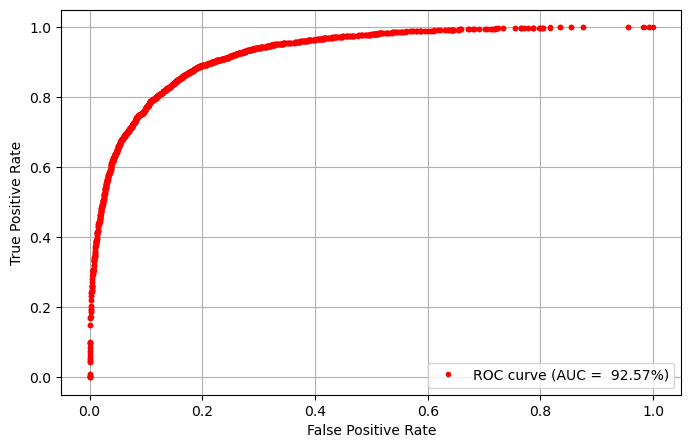

In [55]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,
              )


Time taken: 158.37	Avg loss: 0.361367	Accuracy: 84.05%

Precision: 83.02%	Recall: 85.61%		F1-Score: 84.30%


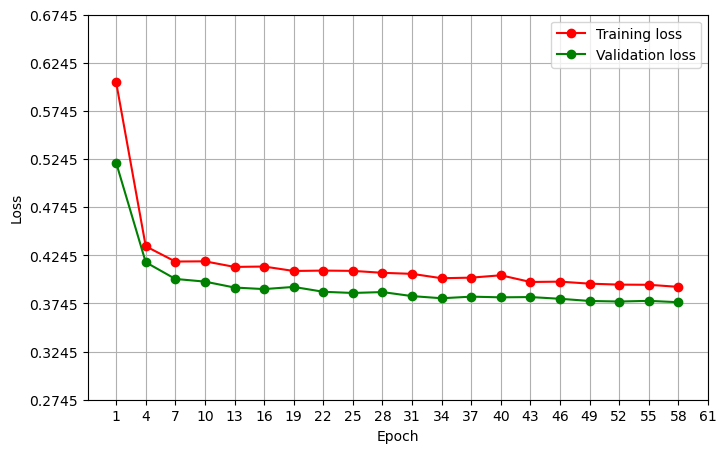

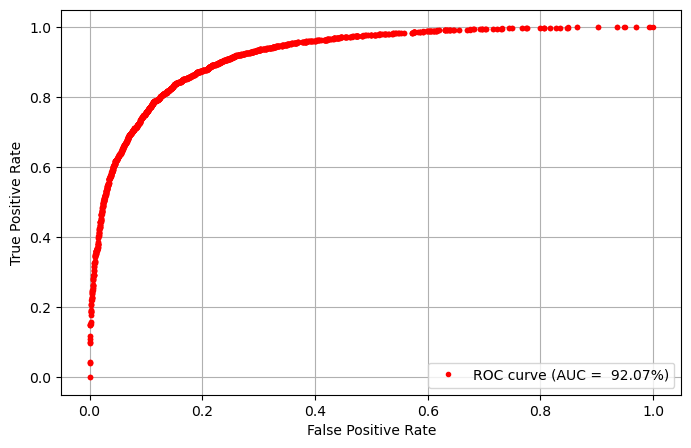

In [56]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 157.63	Avg loss: 0.361559	Accuracy: 84.00%

Precision: 83.00%	Recall: 85.54%		F1-Score: 84.25%


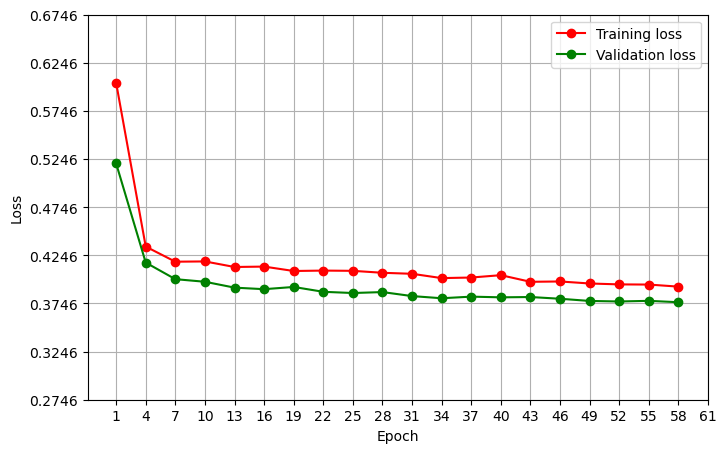

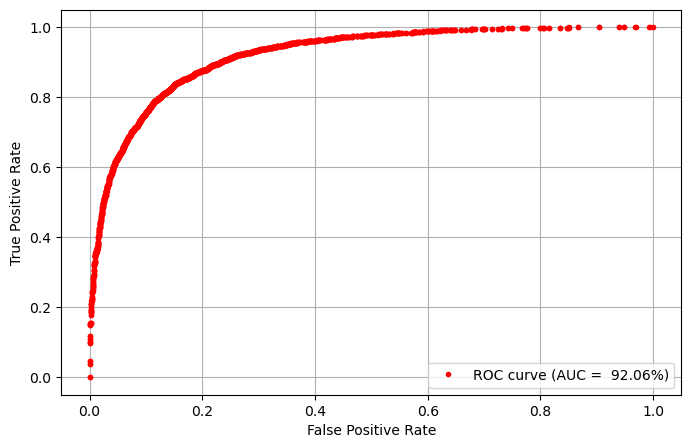

In [57]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 157.86	Avg loss: 0.377569	Accuracy: 83.91%

Precision: 83.37%	Recall: 84.74%		F1-Score: 84.05%


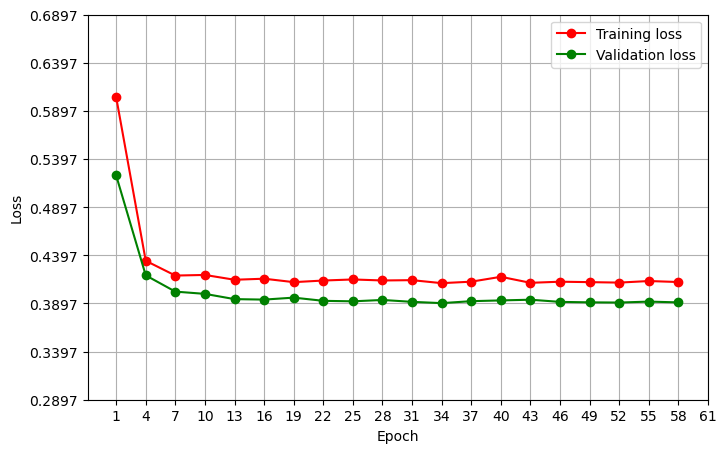

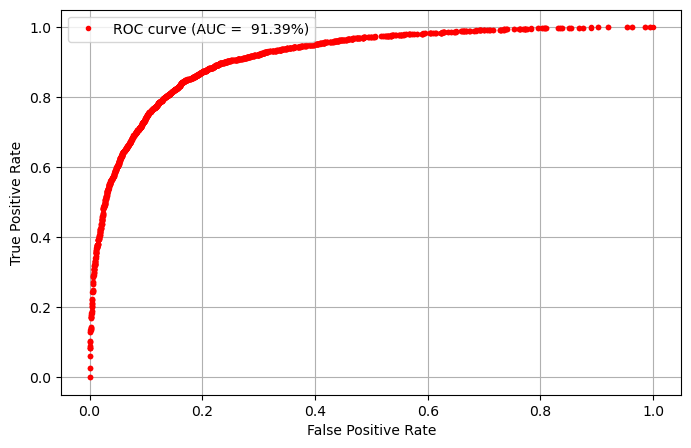

In [58]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 157.07	Avg loss: 0.359704	Accuracy: 84.21%

Precision: 83.45%	Recall: 85.36%		F1-Score: 84.40%


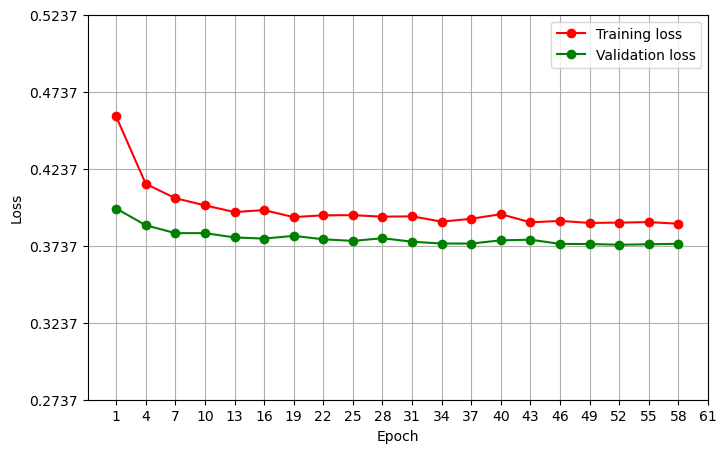

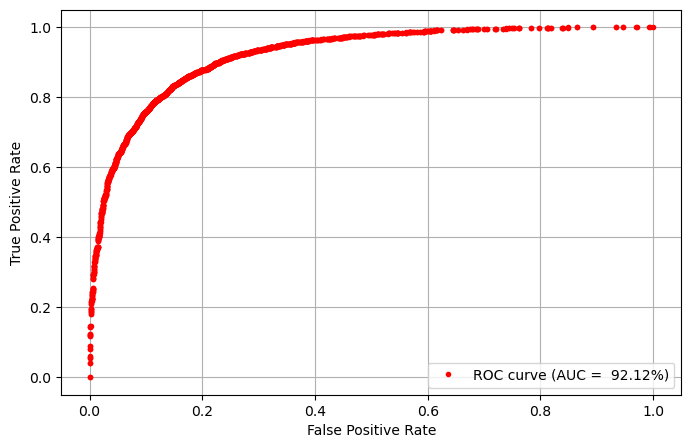

In [59]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 162.98	Avg loss: 0.359849	Accuracy: 84.24%

Precision: 83.43%	Recall: 85.45%		F1-Score: 84.43%


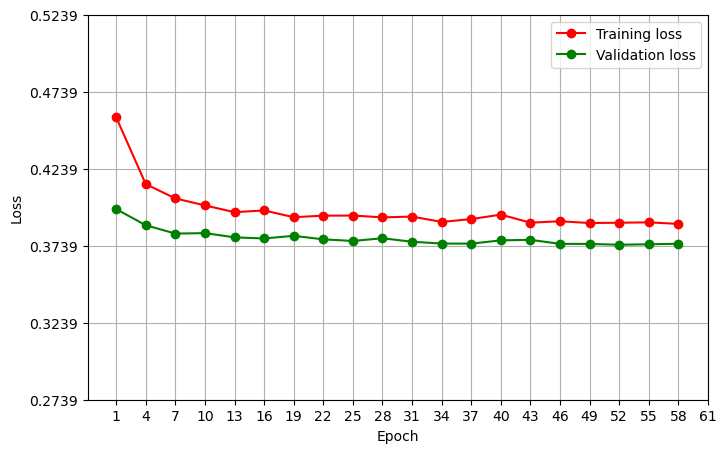

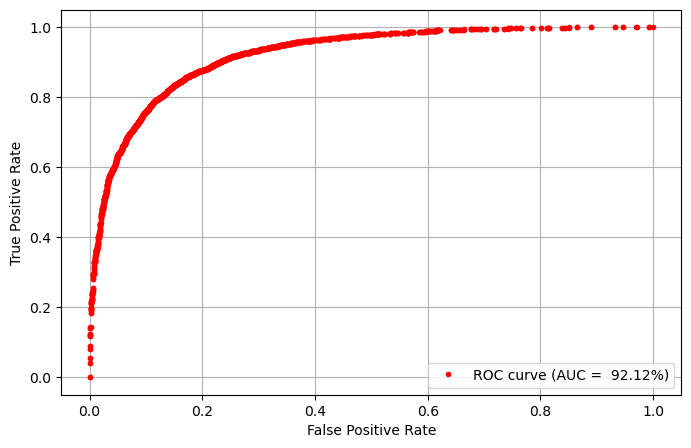

In [60]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 158.52	Avg loss: 0.375264	Accuracy: 83.96%

Precision: 83.25%	Recall: 85.03%		F1-Score: 84.13%


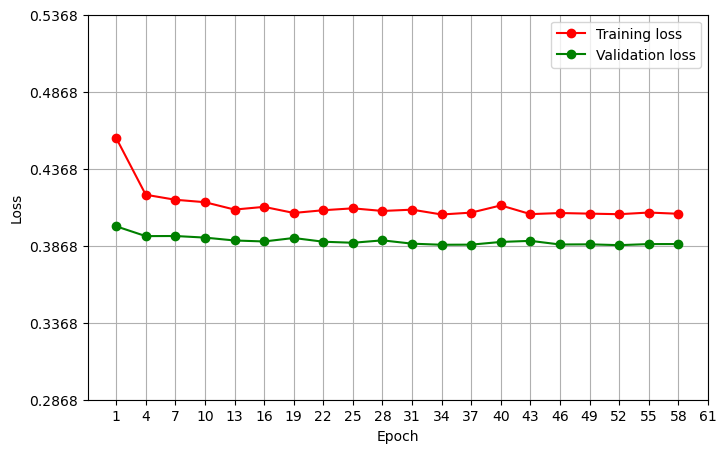

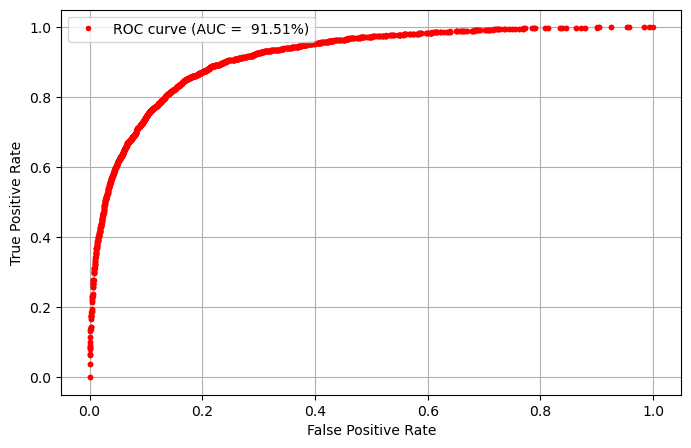

In [61]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 160.62	Avg loss: 0.357595	Accuracy: 84.23%

Precision: 83.53%	Recall: 85.27%		F1-Score: 84.39%


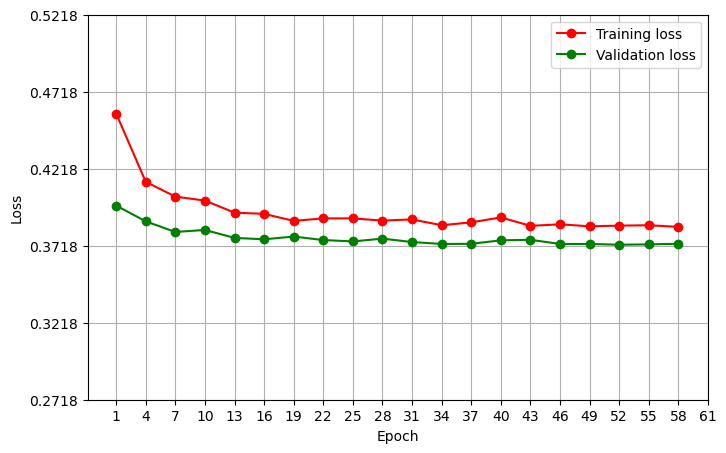

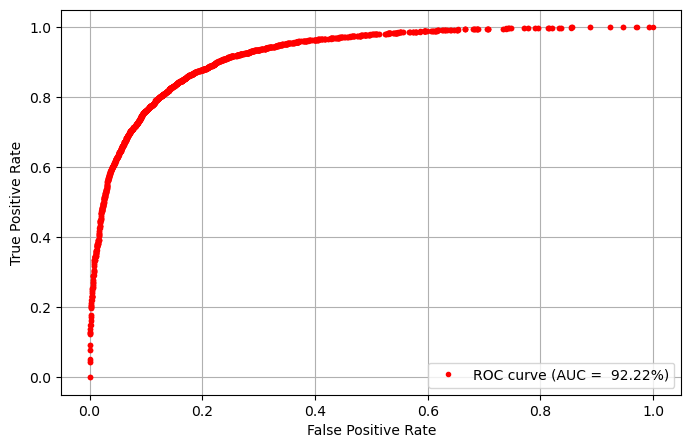

In [62]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 157.71	Avg loss: 0.357532	Accuracy: 84.21%

Precision: 83.41%	Recall: 85.43%		F1-Score: 84.41%


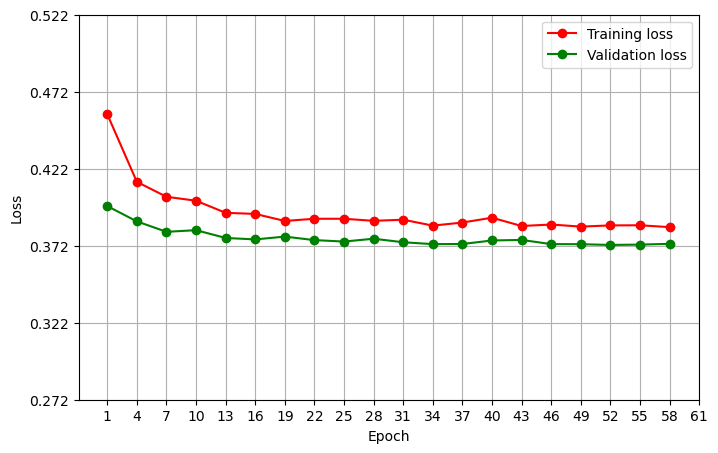

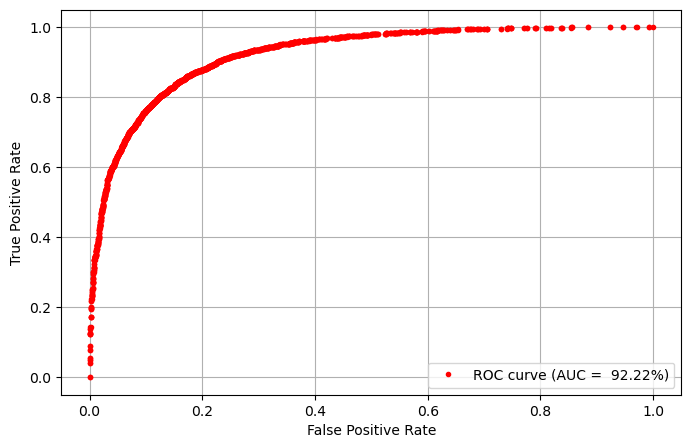

In [63]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 157.56	Avg loss: 0.377599	Accuracy: 83.66%

Precision: 82.27%	Recall: 85.83%		F1-Score: 84.01%


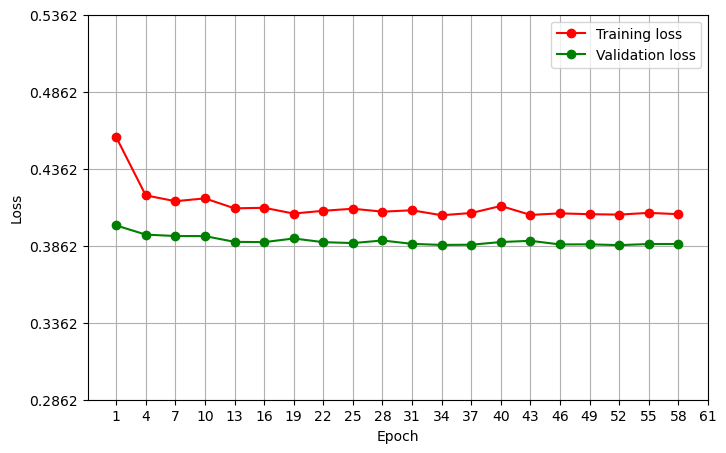

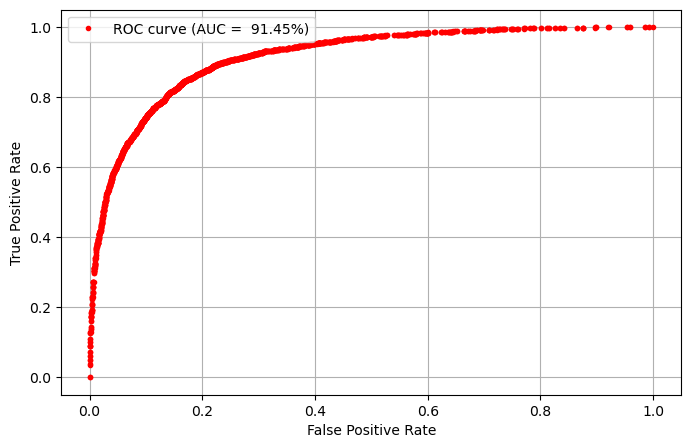

In [64]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )

#### Deep NN

##### Base


Time taken: 266.27	Avg loss: 0.350608	Accuracy: 84.08%

Precision: 81.96%	Recall: 87.41%		F1-Score: 84.60%


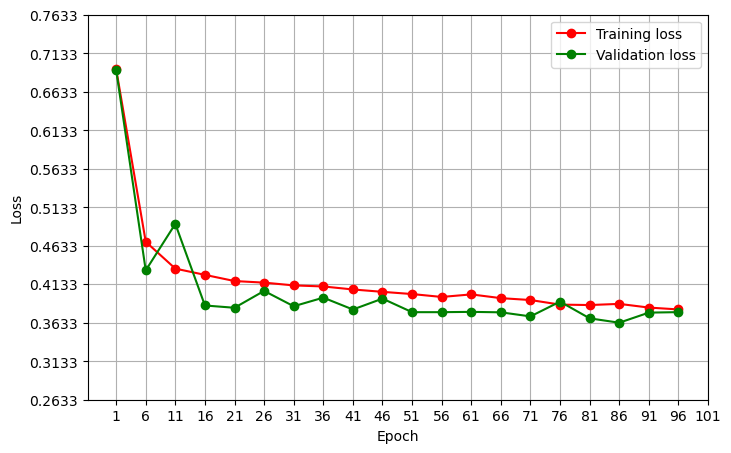

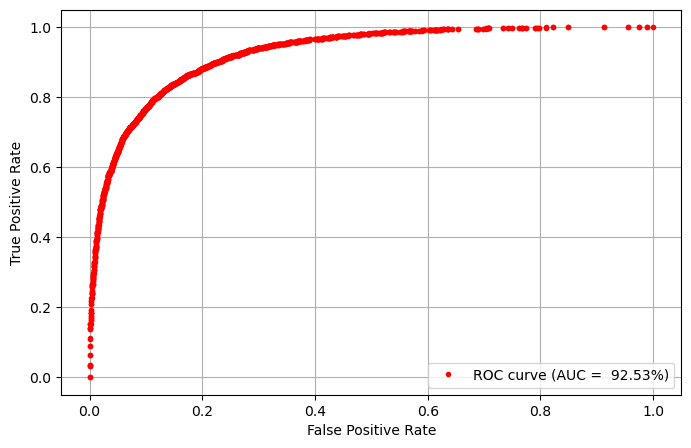

In [65]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=100, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25}
              )


Time taken: 263.77	Avg loss: 0.351070	Accuracy: 84.33%

Precision: 82.60%	Recall: 86.98%		F1-Score: 84.73%


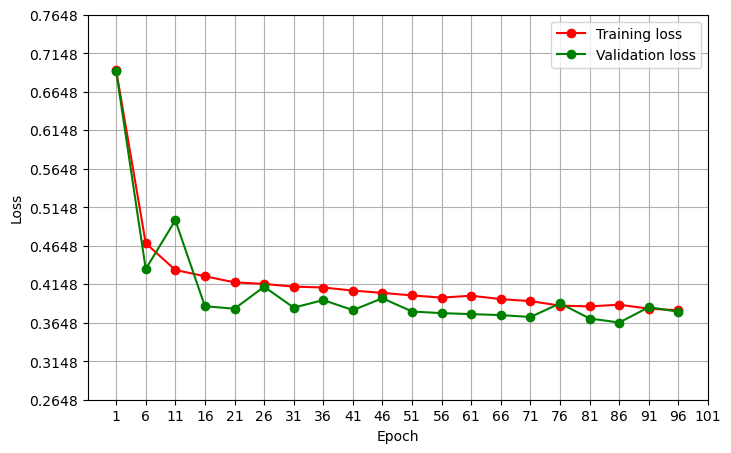

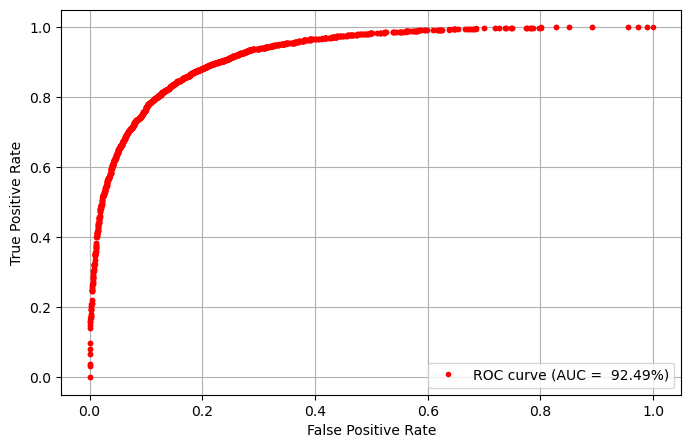

In [66]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=100, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25}
              )


Time taken: 264.04	Avg loss: 0.385545	Accuracy: 83.26%

Precision: 79.90%	Recall: 88.89%		F1-Score: 84.16%


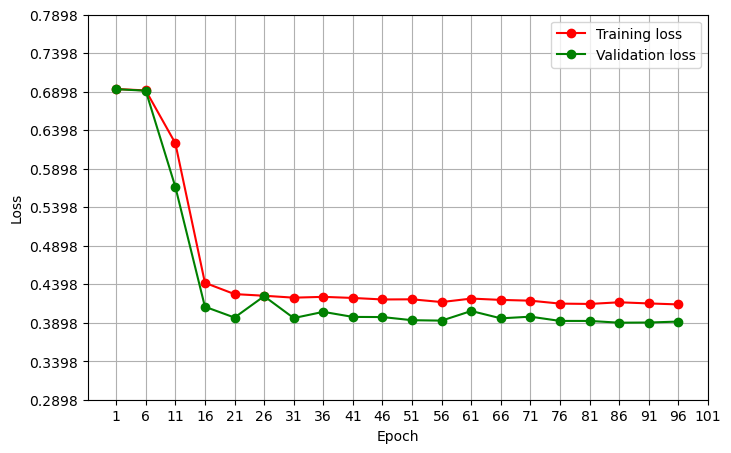

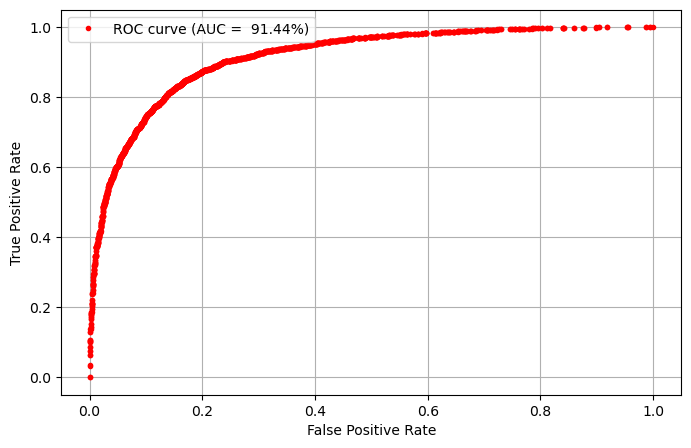

In [67]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.01, epochs=100, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25}
              )

##### Adam


Time taken: 226.68	Avg loss: 0.384823	Accuracy: 84.00%

Precision: 81.12%	Recall: 88.65%		F1-Score: 84.72%


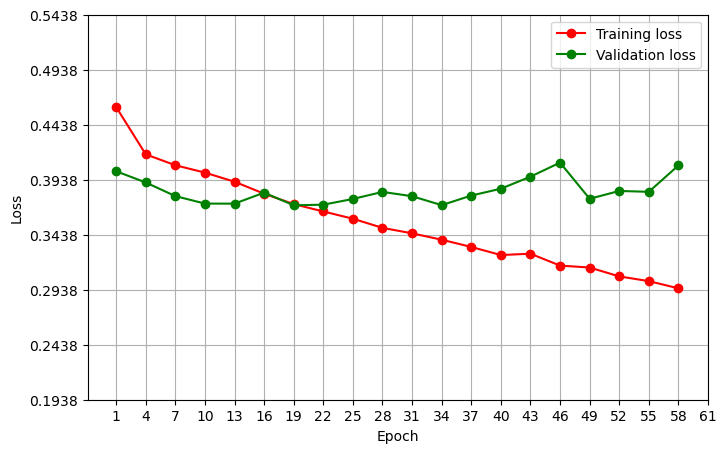

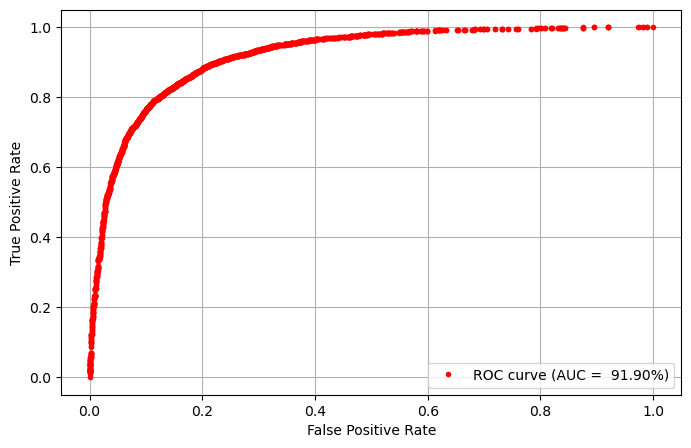

In [68]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adam
              )


Time taken: 230.69	Avg loss: 0.378264	Accuracy: 84.46%

Precision: 83.42%	Recall: 86.03%		F1-Score: 84.70%


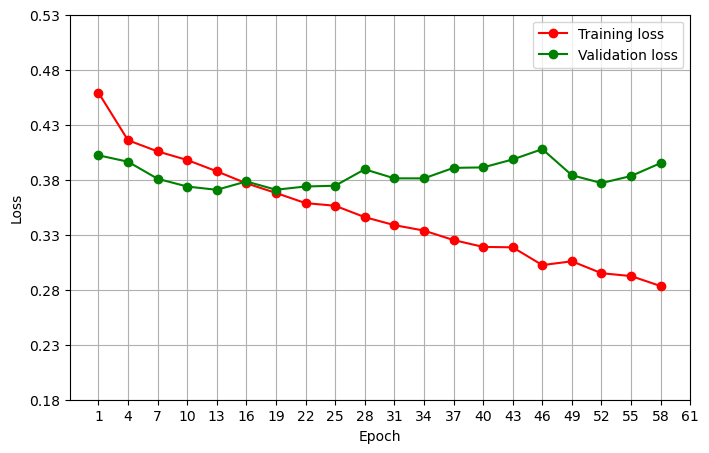

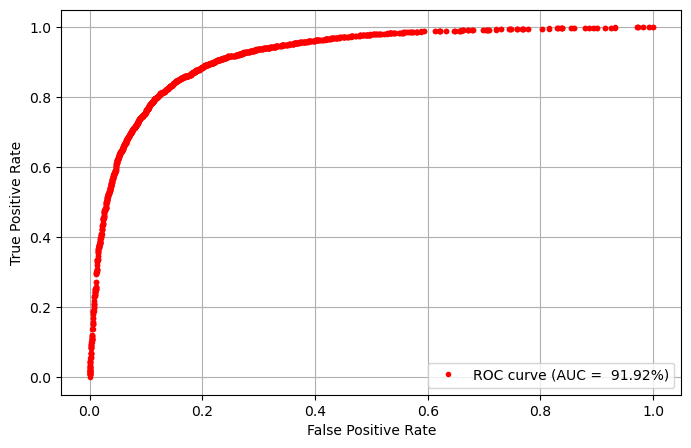

In [69]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adam
              )


Time taken: 227.80	Avg loss: 0.394818	Accuracy: 84.46%

Precision: 84.52%	Recall: 84.38%		F1-Score: 84.45%


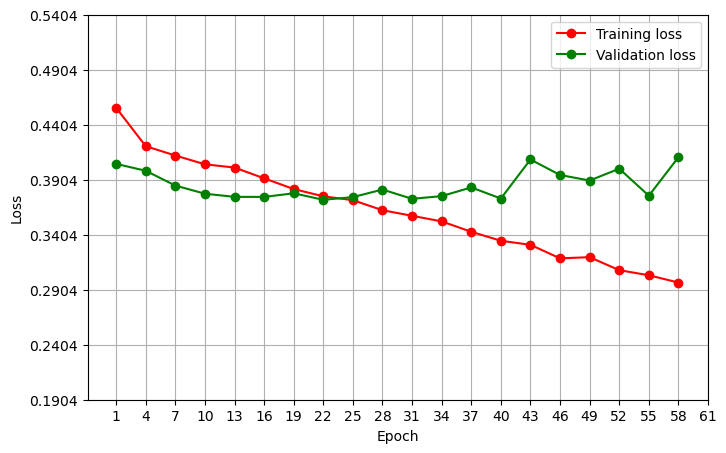

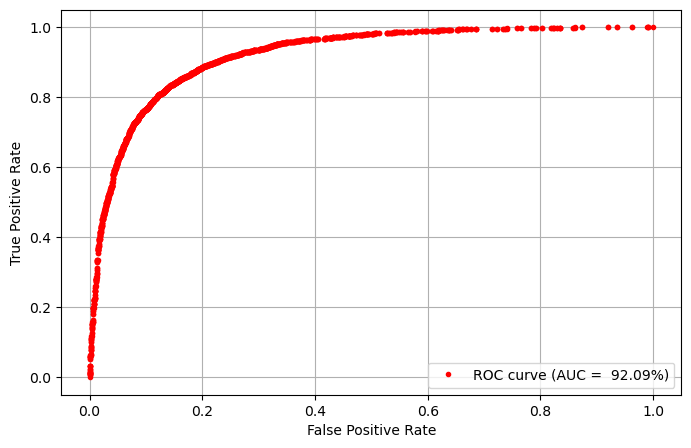

In [70]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adam
              )


Time taken: 227.63	Avg loss: 0.359653	Accuracy: 84.54%

Precision: 82.13%	Recall: 88.29%		F1-Score: 85.10%


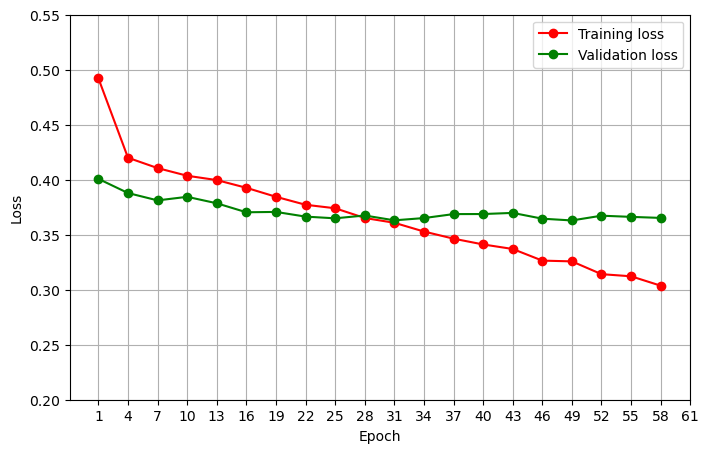

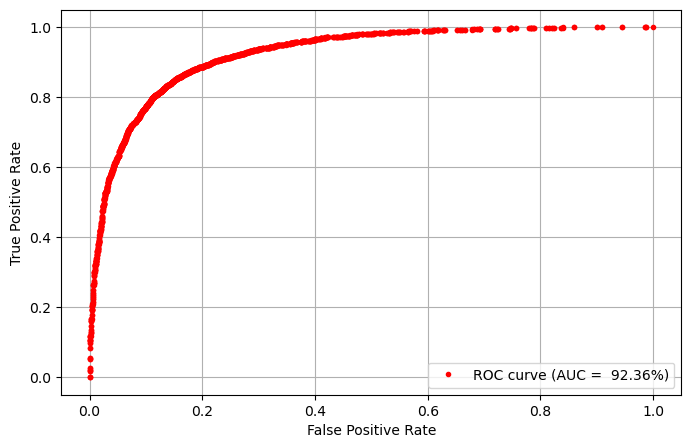

In [71]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 226.84	Avg loss: 0.354380	Accuracy: 84.67%

Precision: 82.97%	Recall: 87.25%		F1-Score: 85.06%


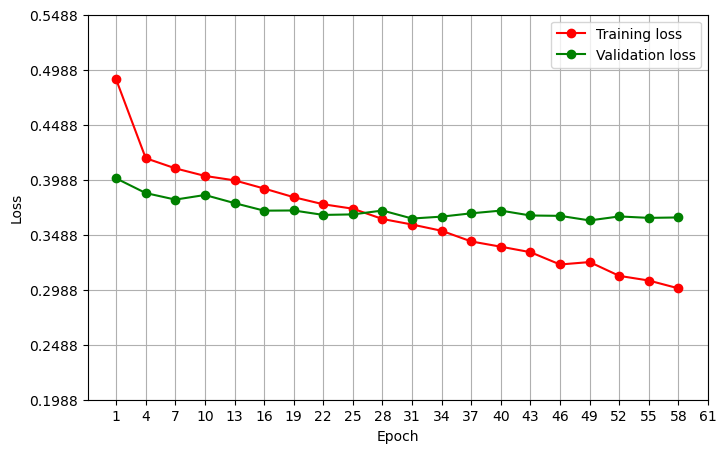

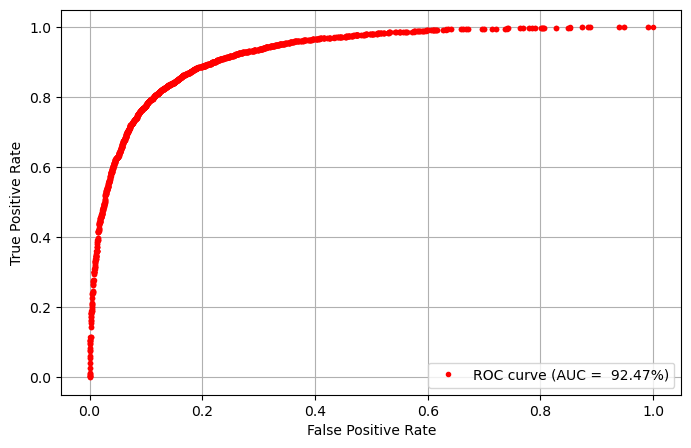

In [72]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 226.92	Avg loss: 0.355535	Accuracy: 84.09%

Precision: 83.27%	Recall: 85.34%		F1-Score: 84.29%


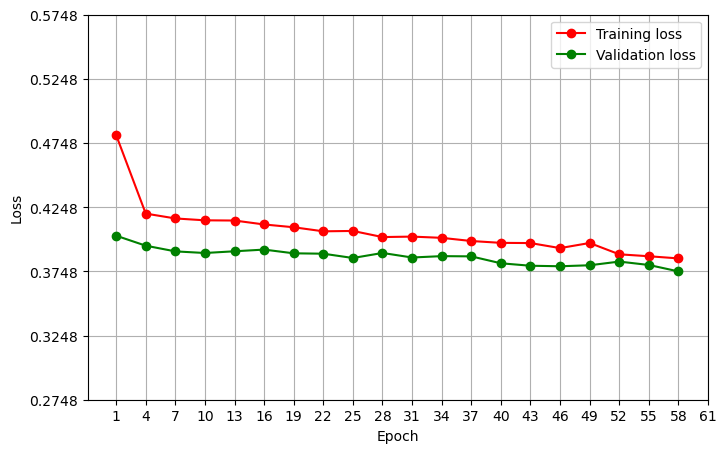

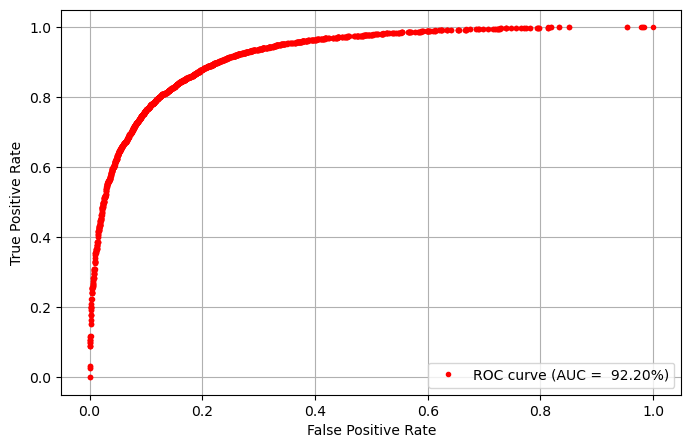

In [73]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 225.31	Avg loss: 0.348104	Accuracy: 84.50%

Precision: 83.10%	Recall: 86.63%		F1-Score: 84.83%


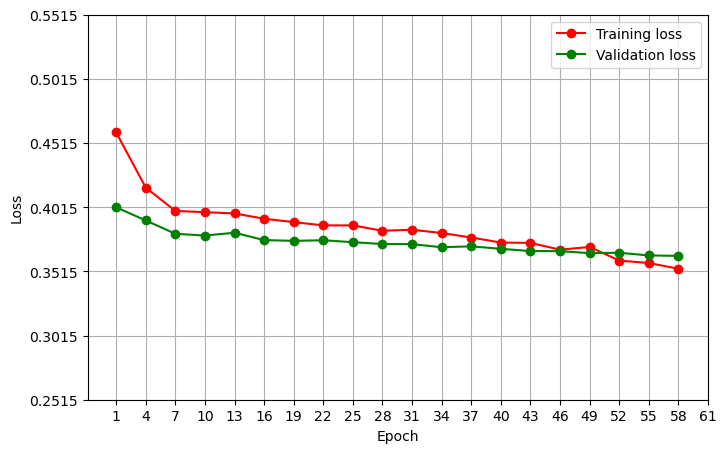

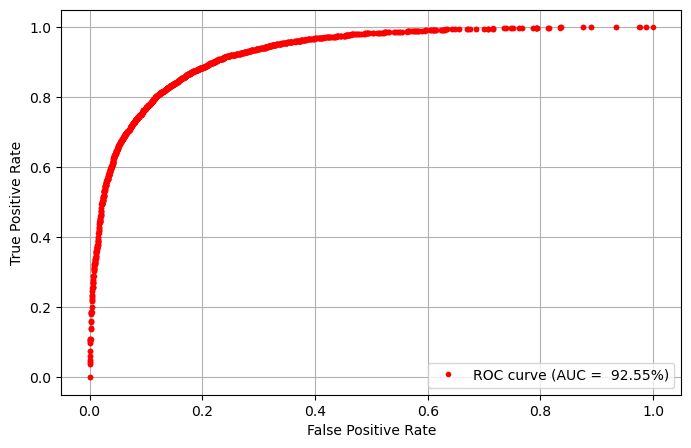

In [74]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 225.30	Avg loss: 0.350804	Accuracy: 84.63%

Precision: 82.63%	Recall: 87.69%		F1-Score: 85.09%


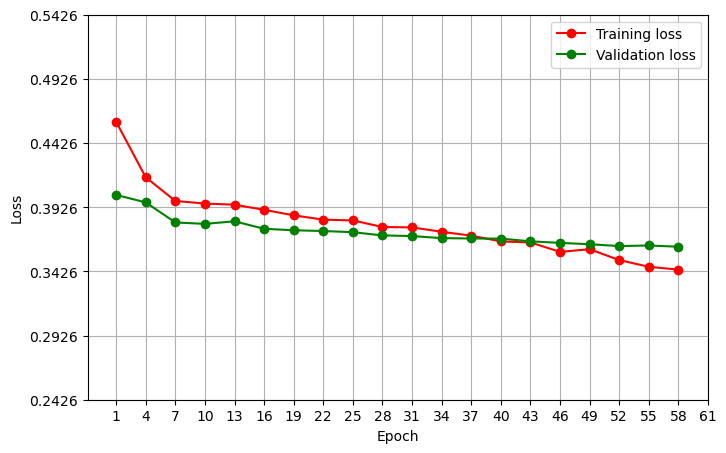

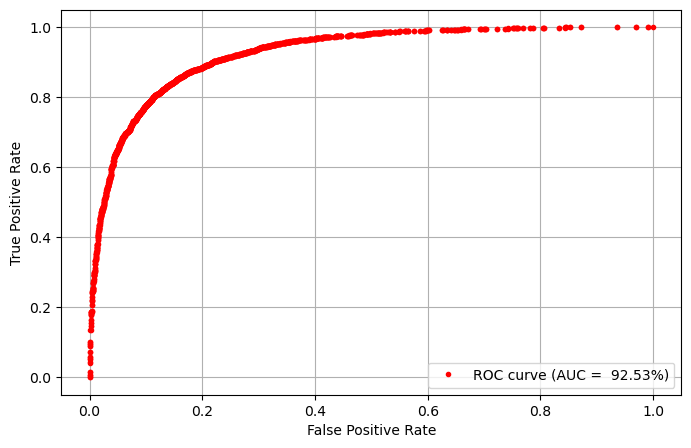

In [75]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 226.61	Avg loss: 0.353321	Accuracy: 84.18%

Precision: 83.30%	Recall: 85.52%		F1-Score: 84.39%


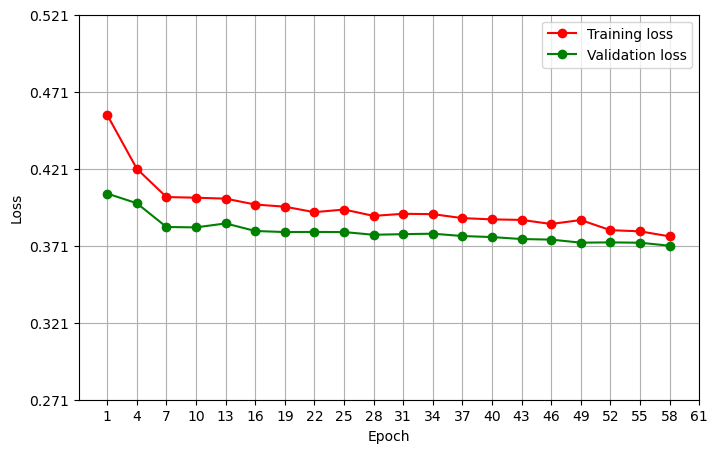

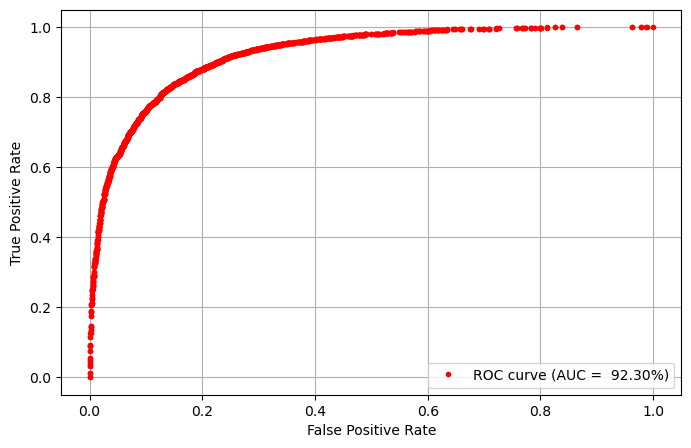

In [76]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adam,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 154.15	Avg loss: 0.352952	Accuracy: 84.41%

Precision: 83.85%	Recall: 85.25%		F1-Score: 84.55%


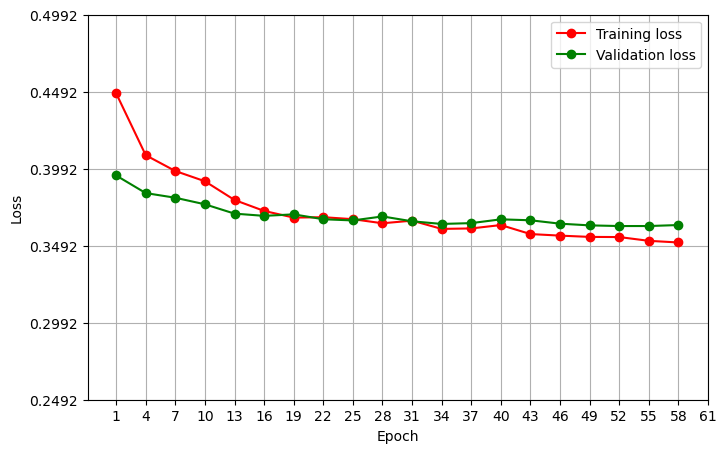

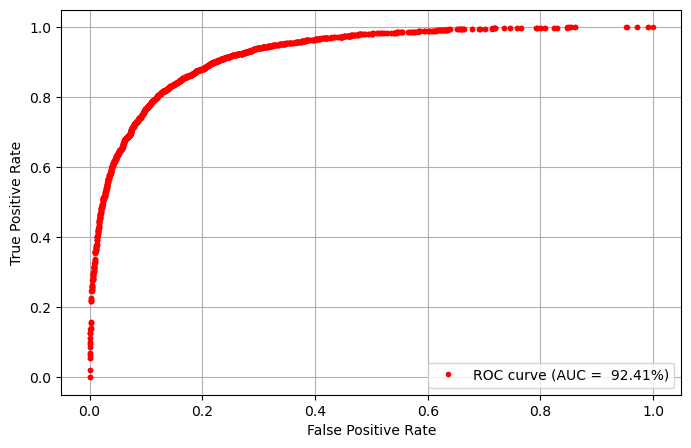

In [77]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 150.78	Avg loss: 0.343661	Accuracy: 84.54%

Precision: 84.01%	Recall: 85.32%		F1-Score: 84.66%


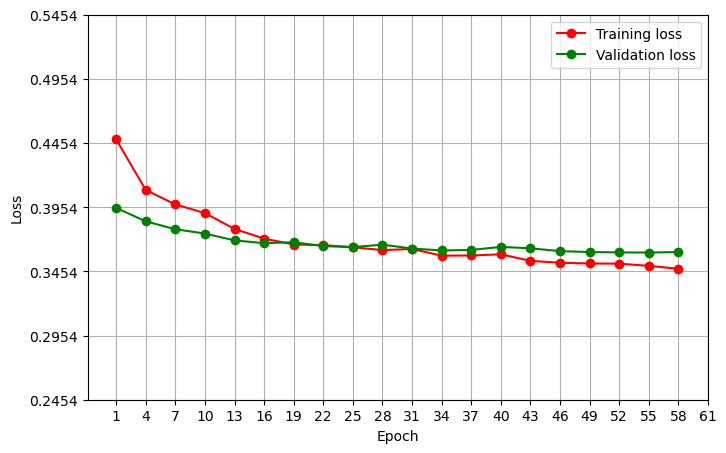

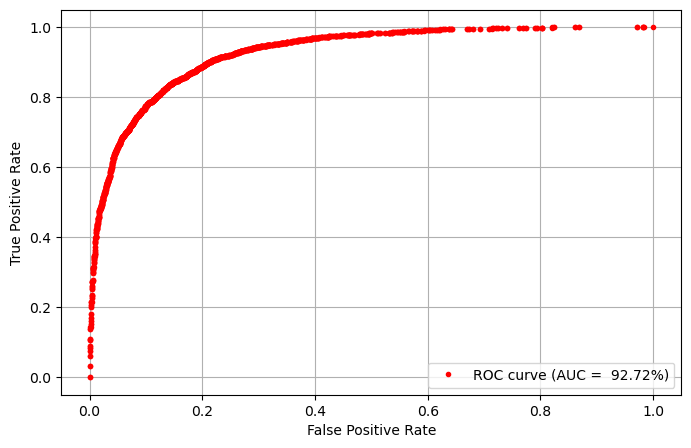

In [78]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 149.88	Avg loss: 0.360704	Accuracy: 84.24%

Precision: 83.56%	Recall: 85.25%		F1-Score: 84.40%


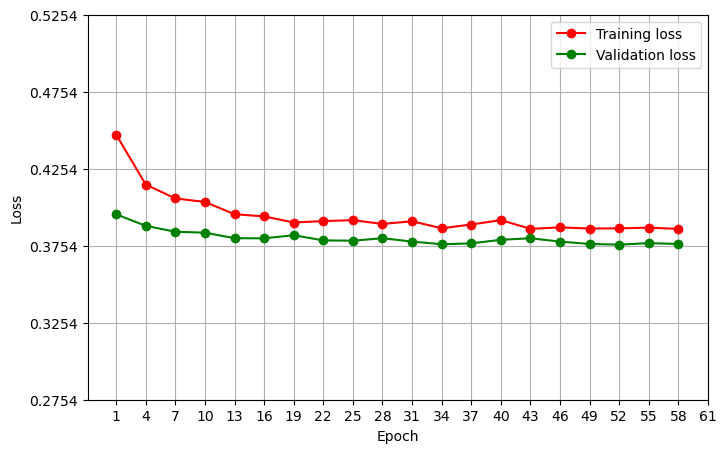

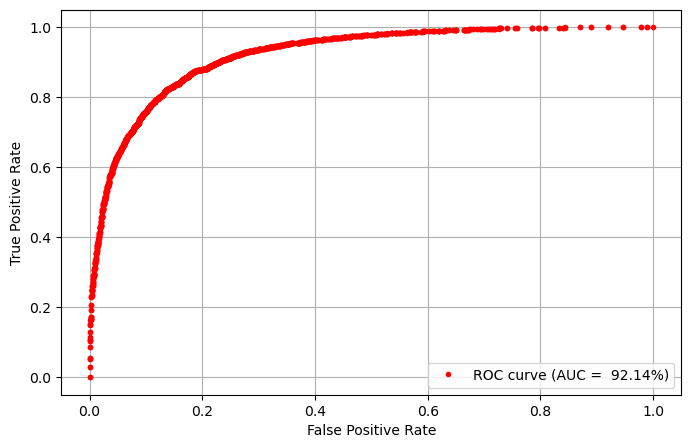

In [79]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25, 'layers' : [1024]},

              optimizer=Adam,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )

##### Adamax


Time taken: 243.71	Avg loss: 0.355502	Accuracy: 84.63%

Precision: 83.21%	Recall: 86.76%		F1-Score: 84.95%


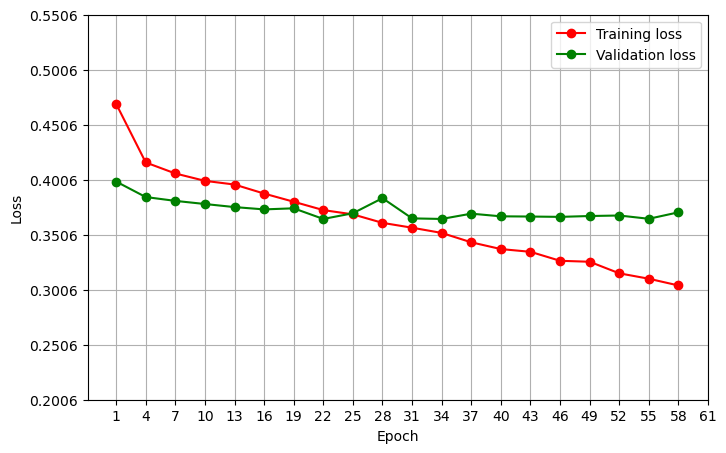

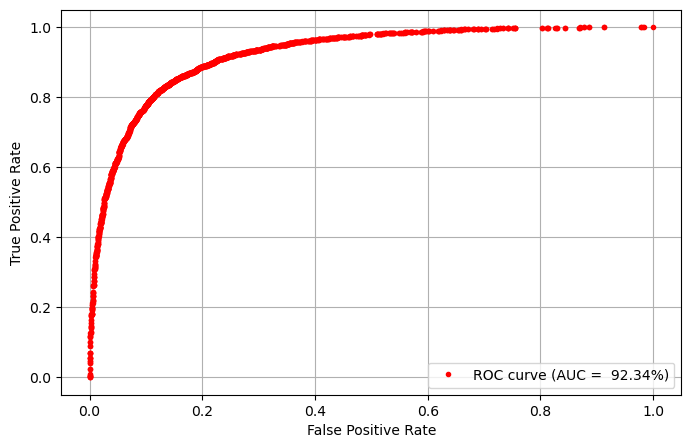

In [80]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adamax
              )


Time taken: 245.86	Avg loss: 0.354019	Accuracy: 84.91%

Precision: 84.61%	Recall: 85.36%		F1-Score: 84.98%


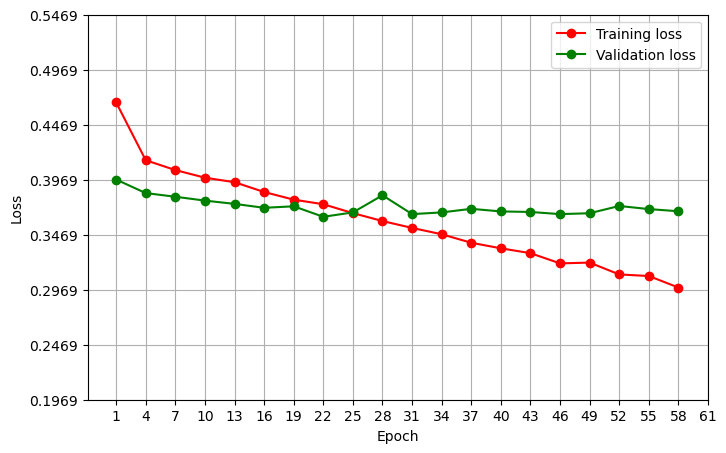

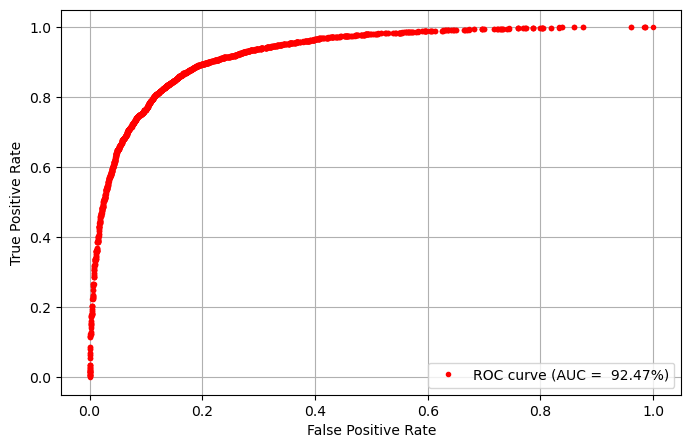

In [81]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adamax
              )


Time taken: 243.63	Avg loss: 0.360496	Accuracy: 83.86%

Precision: 81.77%	Recall: 87.16%		F1-Score: 84.38%


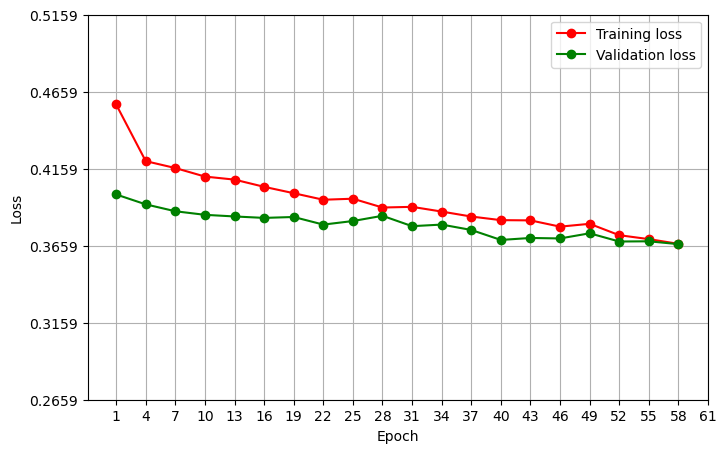

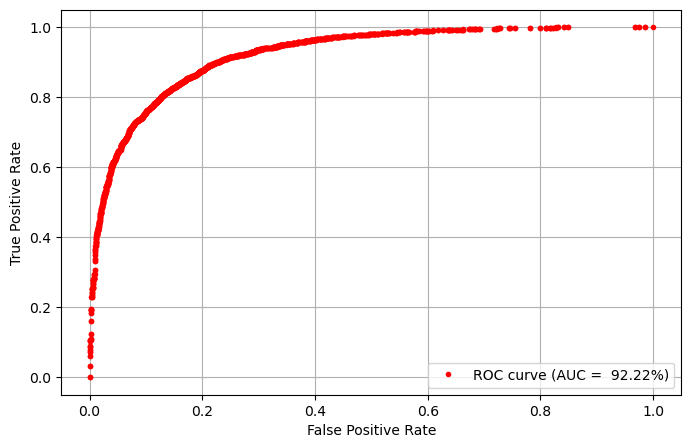

In [82]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adamax
              )


Time taken: 245.91	Avg loss: 0.352239	Accuracy: 84.55%

Precision: 83.55%	Recall: 86.05%		F1-Score: 84.78%


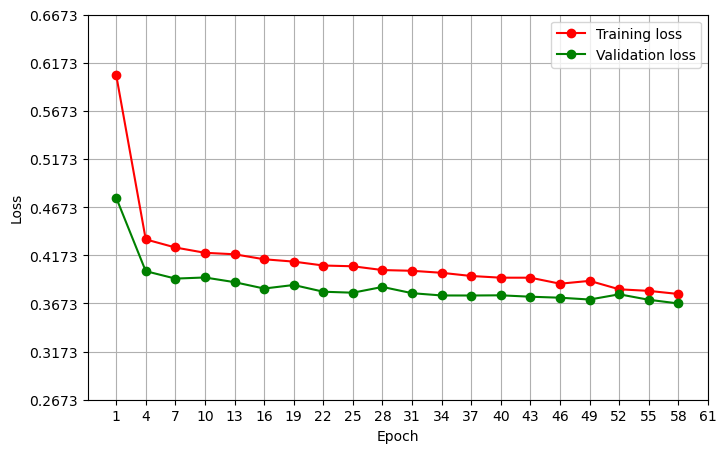

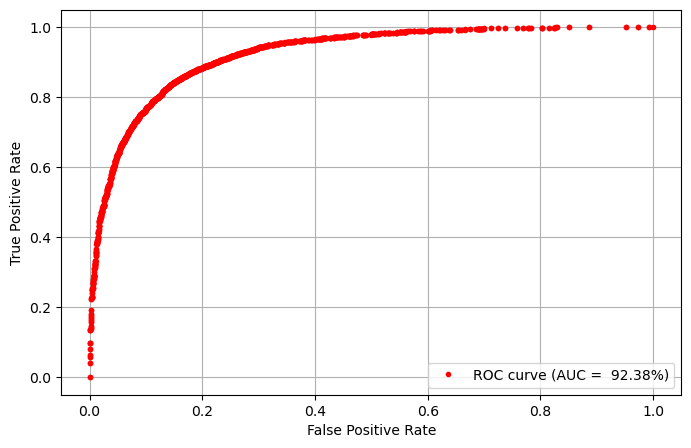

In [83]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 245.33	Avg loss: 0.351937	Accuracy: 84.56%

Precision: 83.84%	Recall: 85.63%		F1-Score: 84.73%


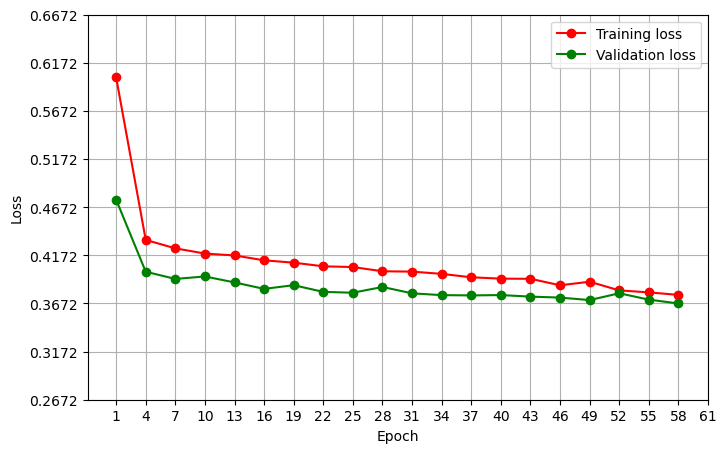

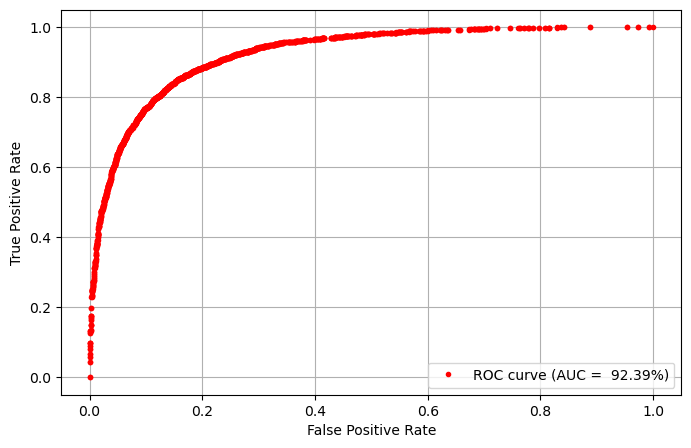

In [84]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 246.28	Avg loss: 0.375514	Accuracy: 83.59%

Precision: 81.60%	Recall: 86.76%		F1-Score: 84.10%


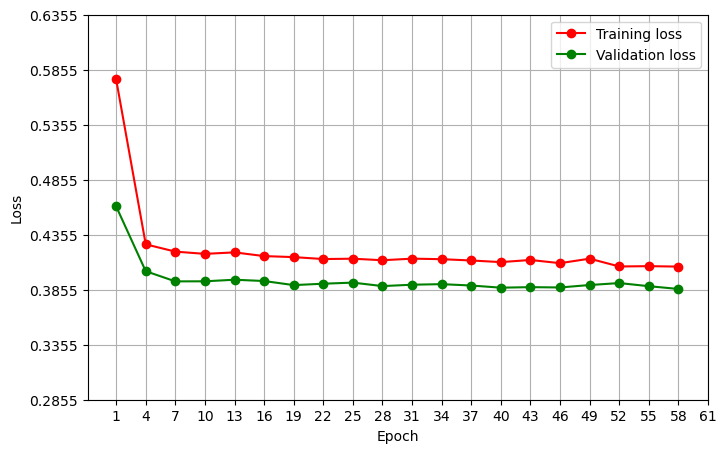

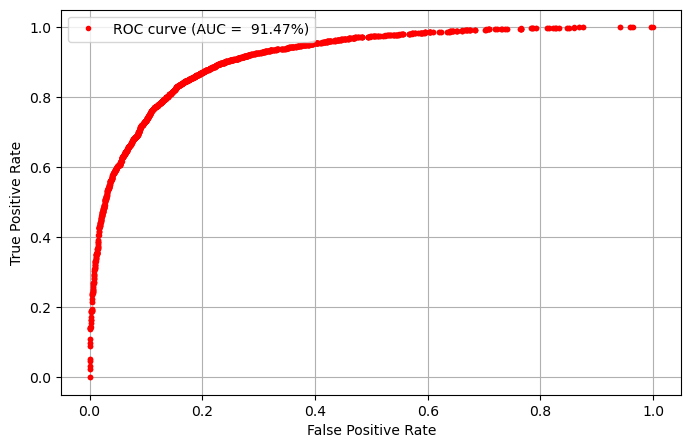

In [85]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=CyclicLR, scheduler_params={'base_lr': 0.0001, 'max_lr': 0.001, 'cycle_momentum': False},
              )


Time taken: 246.46	Avg loss: 0.358736	Accuracy: 84.20%

Precision: 84.21%	Recall: 84.21%		F1-Score: 84.21%


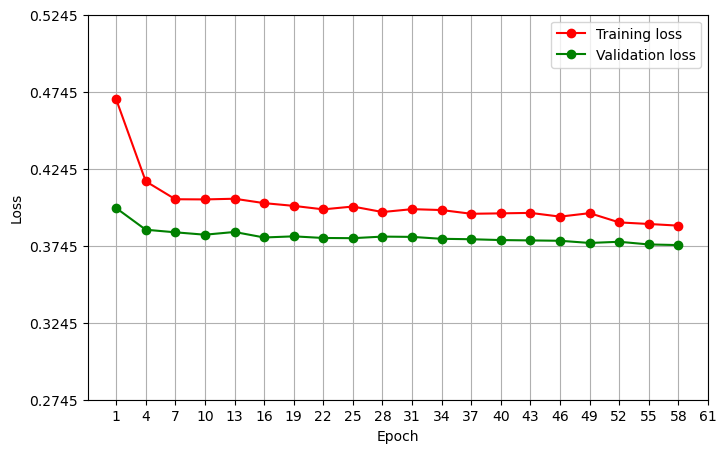

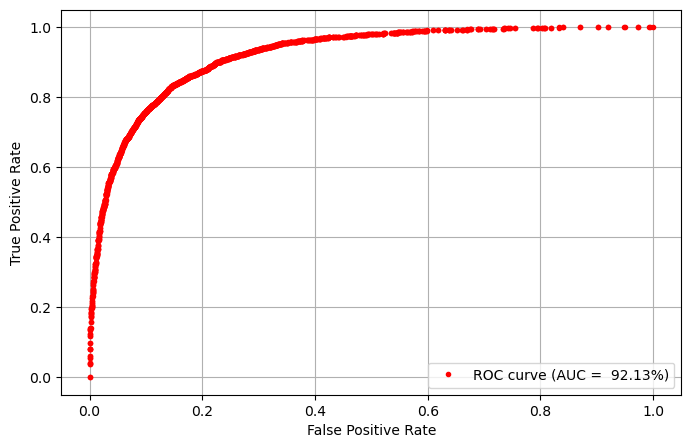

In [86]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 247.26	Avg loss: 0.357685	Accuracy: 84.21%

Precision: 84.15%	Recall: 84.32%		F1-Score: 84.23%


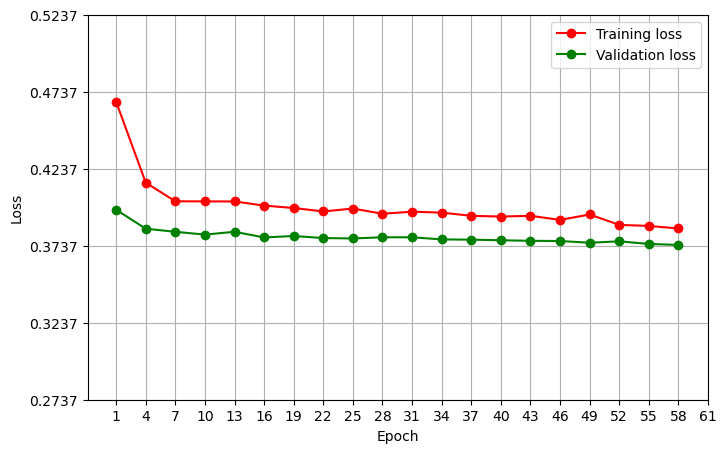

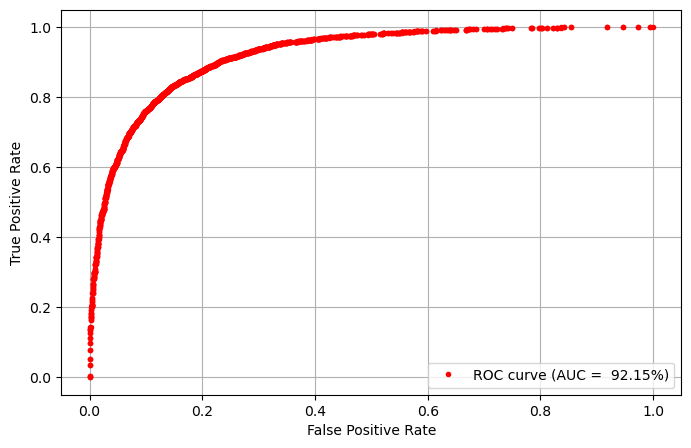

In [87]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 246.81	Avg loss: 0.369760	Accuracy: 83.91%

Precision: 83.21%	Recall: 84.98%		F1-Score: 84.09%


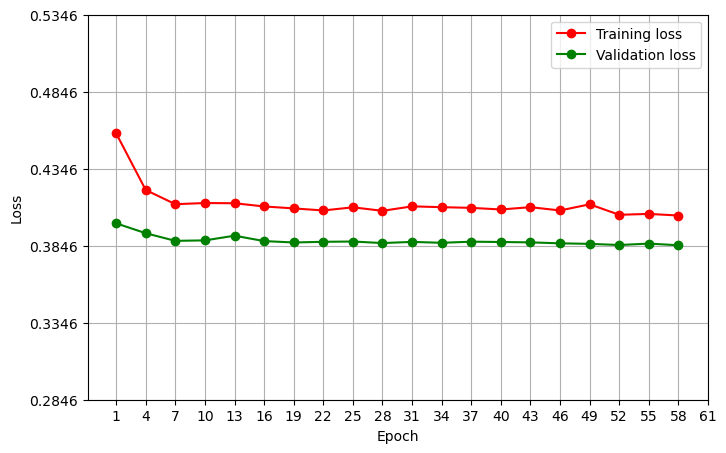

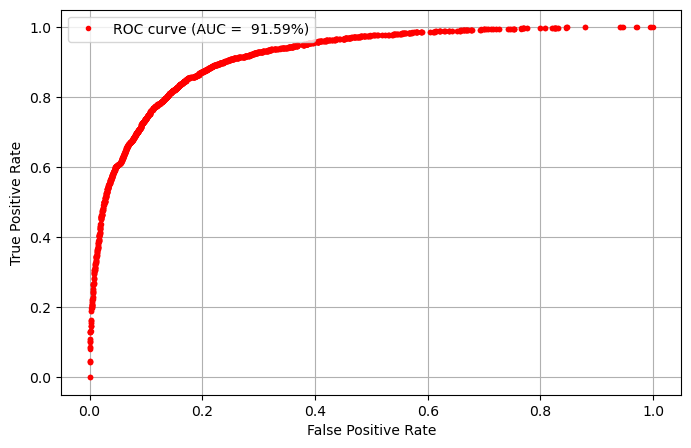

In [88]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60, 
              
              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},
              
              optimizer=Adamax,

              scheduler=ReduceLROnPlateau, scheduler_params={'patience': 1, 'min_lr': 0.00005, 'factor' : 0.0001, 'pass_loss' : True},
              )


Time taken: 239.76	Avg loss: 0.352213	Accuracy: 84.56%

Precision: 84.26%	Recall: 85.01%		F1-Score: 84.63%


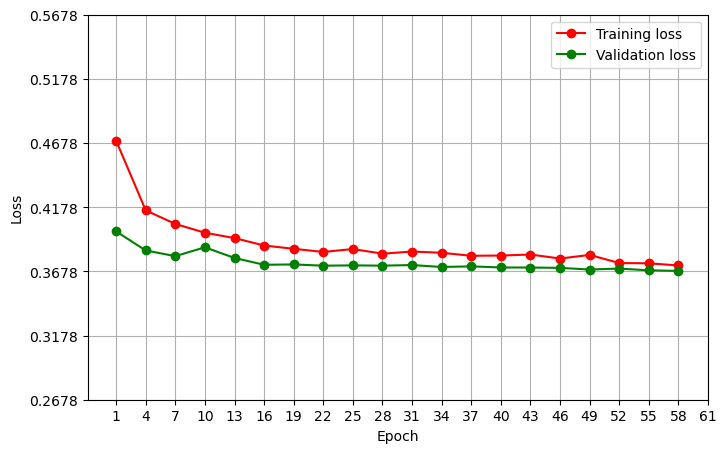

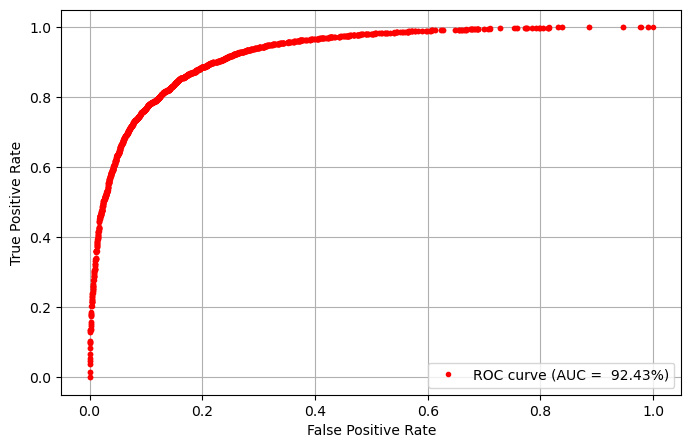

In [89]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : ReLU, 'dropout' : 0.25},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 245.84	Avg loss: 0.352238	Accuracy: 84.47%

Precision: 84.49%	Recall: 84.45%		F1-Score: 84.47%


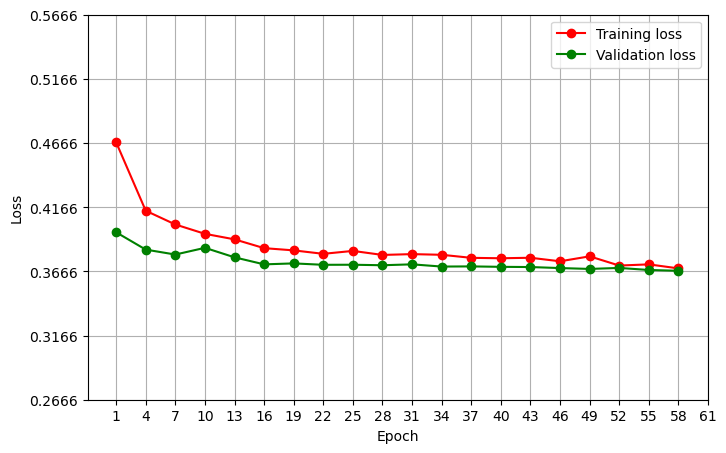

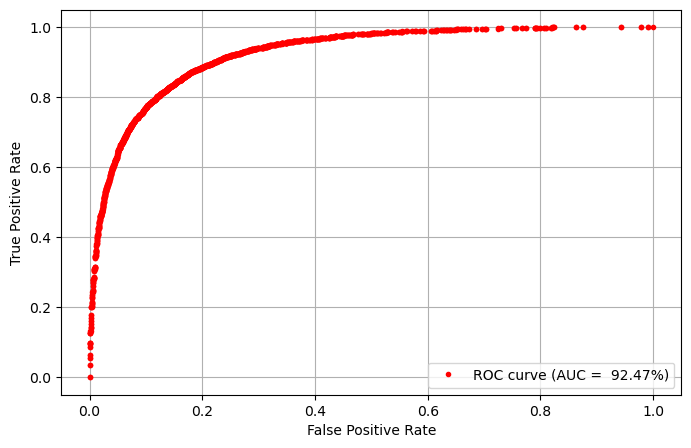

In [90]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : LeakyReLU, 'dropout' : 0.25},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )


Time taken: 244.02	Avg loss: 0.366958	Accuracy: 83.78%

Precision: 83.27%	Recall: 84.56%		F1-Score: 83.91%


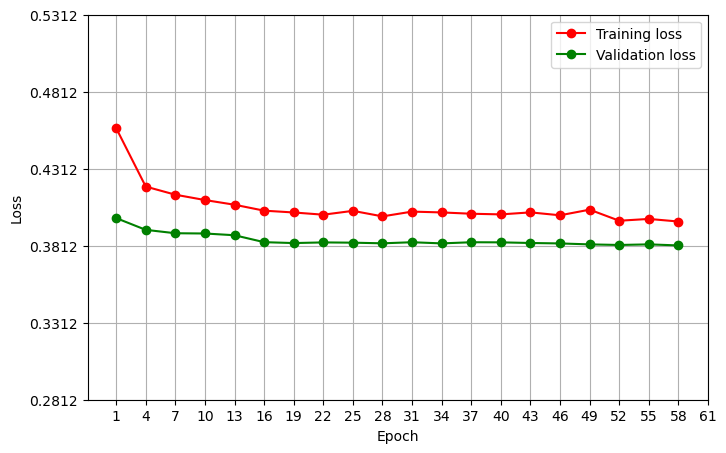

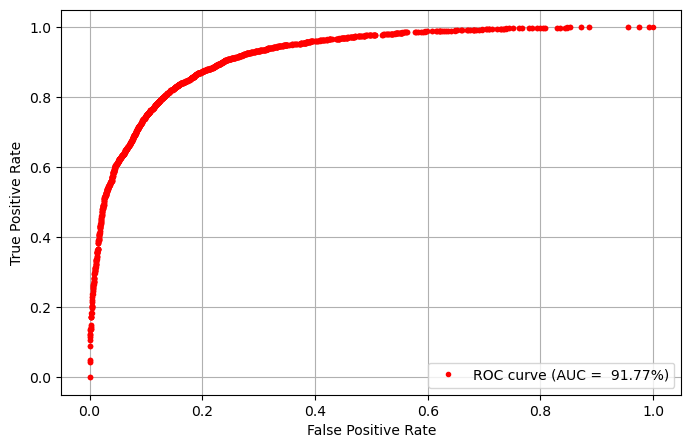

In [91]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True,
              
              device='cuda', lr=0.001, epochs=60,

              model=NeuralNetwork, model_params={'in_dim' : 300, 'activation' : GELU, 'dropout' : 0.25},

              optimizer=Adamax,

              scheduler=LinearLR, scheduler_params={'start_factor' : 1., 'end_factor' : 0.05, 'total_iters' : 15}
              )